<a href="https://colab.research.google.com/github/copanea/MyGitProject/blob/feature%2Fcart/hongjejoon/%EC%B6%A9%EC%A0%84%EC%86%8C%EC%9C%84%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 시스템
import os
import datetime
import requests
import json

# 다량 데이터 처리시 진행상황 표시
from tqdm import tqdm

# 데이터 처리 관련
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.13f}".format # display()에서 float는 소수점 이하 13자리까지 표시

# 지도 시각화
import folium

# 지리정보 처리
from geopy.geocoders import Nominatim
import googlemaps

# matplotlib 및 한글 폰트 설정
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import matplotlib.font_manager as fm
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # Linux 기준
# font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family='NanumGothic')  # 나눔고딕 사용
matplotlib.rcParams['axes.unicode_minus'] = False

# 각종 데이터셋 파일들 저장된 경로
dataset_path = '../../data'

# API KEY: dataset_path 내 apikeys.json 파일에 다음과 같은 형태로 저장
# {
# 	"apikeys": {
# 		"datagokr": "API Key 값", //공공데이터포털(data.go.kr) OpenAPI
# 		"naver_id": "API Key 값", //네이버 클라우드 GeoCoding API
# 		"naver":    "API Key 값", //네이버 클라우드 GeoCoding API
# 		"vworld":   "API Key 값", //국토교통부 V-World 디지털트윈국토 OpenAPI
# 		"kakao":    "API Key 값", //카카오맵 API
# 		"google":   "API Key 값"  //Google Maps API
# 	}
# }
# 각 사이트별로 API Key를 발급받아서 사용하면 됩니다.
# !! API KEY를 본 코드에 직접 입력하지 마시고, apikeys.json 파일을 이용해주세요!
with open(f'{dataset_path}/apikeys.json') as json_file:
	apikey = json.load(json_file)['apikeys']
print(f'API keys loaded: {list(apikey.keys())}')

API keys loaded: ['datagokr', 'naver_id', 'naver', 'vworld', 'kakao', 'google']


# 데이터 불러오기

## 한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황

In [ ]:
keco_chargestations = pd.read_csv(f'{dataset_path}/한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황.csv', encoding='cp949')
display(keco_chargestations)

,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,충전기ID
0,서울특별시,강남구,서울특별시 강남구 봉은사로 130,노보텔,상업시설,숙박시설,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1
1,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1
2,서울특별시,강동구,서울특별시 강동구 선사로 70,천호유수지 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1
3,서울특별시,강동구,서울특별시 강동구 진황도로29길 34,천호3동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1
4,서울특별시,강서구,서울특별시 강서구 가로공원로 189,가로공원로 지하공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191509,강원도,원주시,강원도 원주시 지정면 무릉로 43,팬더프라자,상업시설,마트(쇼핑몰),완속,AC완속,타기관,한화솔루션,NaN,AC완속,이용가능,5
191510,강원도,원주시,강원도 원주시 지정면 무릉로 43,팬더프라자,상업시설,마트(쇼핑몰),완속,AC완속,타기관,한화솔루션,NaN,AC완속,이용가능,6
191511,제주특별자치도,제주시,제주특별자치도 제주시 명림로 575-107,한화리조트 제주,상업시설,숙박시설,완속,AC완속,타기관,한화솔루션,NaN,AC완속,이용가능,1
191512,제주특별자치도,제주시,제주특별자치도 제주시 명림로 575-107,한화리조트 제주,상업시설,숙박시설,급속,DC콤보,타기관,한화솔루션,NaN,DC콤보,이용가능,2


## 한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531

### 불러오기

In [ ]:
keco_chargers_20230531_origin = pd.read_csv(
	f'{dataset_path}/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531.csv',
	encoding='cp949',
	dtype={
		'설치년도': 	int,
		'시도':			str,
		'군구':			str,
		'주소':			str,
		'충전소명':		str,
		'시설구분(대)':	str,
		'시설구분(소)':	str,
		'기종(대)':		str,
		'기종(소)':		str,
		'운영기관(대)':	str,
		'운영기관(소)':	str,
		'급속충전량':	str,
		'충전기타입':	str,
		'이용자제한':	str,
		'위도경도':		str,
	}
)
display(keco_chargers_20230531_origin)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,위도경도
0,2017,서울특별시,강서구,서울특별시 강서구 가로공원로 189,가로공원로 지하공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.5372628,126.8383789"
1,2017,서울특별시,강서구,서울특별시 강서구 강서로5길 50,곰달래문화복지센터 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.5289561,126.8490887"
2,2017,서울특별시,강서구,서울특별시 강서구 까치산로4길 22,볏골공원 지하공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.5419747,126.8444499"
3,2017,서울특별시,강서구,서울특별시 강서구 우장산로 114,화곡6-1 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.5530457,126.8488169"
4,2017,서울특별시,관악구,서울특별시 관악구 관천로 98,신림동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.4874046,126.9235075"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361158,2015,광주광역시,남구,광주광역시 남구 화산로 30,진월국제테니스장,공공시설,지자체시설,급속,DC차데모+AC3상+DC콤보,지자체,지자체기타,NaN,DC차데모+AC3상+DC콤보,이용자제한,NaN
361159,2016,전라남도,영광군,전라남도 영광군 군서면 백수로 1481,농업기술센터,공공시설,지자체시설,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,NaN
361160,2016,전라남도,영광군,전라남도 영광군 영광읍 월현로 170,스포티움 수영장,공공시설,지자체시설,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,NaN
361161,2011,전라남도,강진군,전라남도 강진군 강진읍 탐진로 111,강진군청,공공시설,관공서,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,NaN


### 위도경도 column 분리 및 source 표시

In [ ]:
keco_chargers_20230531_origin['위도'] = keco_chargers_20230531_origin['위도경도'].str.split(',').str[0].astype(float)
keco_chargers_20230531_origin['경도'] = keco_chargers_20230531_origin['위도경도'].str.split(',').str[1].astype(float)
keco_chargers_20230531_origin.loc[~keco_chargers_20230531_origin['위도경도'].isna(), 'source'] = 'dataset'
display(keco_chargers_20230531_origin)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,위도경도,위도,경도,source
0,2017,서울특별시,강서구,서울특별시 강서구 가로공원로 189,가로공원로 지하공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.5372628,126.8383789",37.5372628000000,126.8383789000000,dataset
1,2017,서울특별시,강서구,서울특별시 강서구 강서로5길 50,곰달래문화복지센터 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.5289561,126.8490887",37.5289561000000,126.8490887000000,dataset
2,2017,서울특별시,강서구,서울특별시 강서구 까치산로4길 22,볏골공원 지하공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.5419747,126.8444499",37.5419747000000,126.8444499000000,dataset
3,2017,서울특별시,강서구,서울특별시 강서구 우장산로 114,화곡6-1 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.5530457,126.8488169",37.5530457000000,126.8488169000000,dataset
4,2017,서울특별시,관악구,서울특별시 관악구 관천로 98,신림동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,"37.4874046,126.9235075",37.4874046000000,126.9235075000000,dataset
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361158,2015,광주광역시,남구,광주광역시 남구 화산로 30,진월국제테니스장,공공시설,지자체시설,급속,DC차데모+AC3상+DC콤보,지자체,지자체기타,NaN,DC차데모+AC3상+DC콤보,이용자제한,NaN,NaN,NaN,NaN
361159,2016,전라남도,영광군,전라남도 영광군 군서면 백수로 1481,농업기술센터,공공시설,지자체시설,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,NaN,NaN,NaN,NaN
361160,2016,전라남도,영광군,전라남도 영광군 영광읍 월현로 170,스포티움 수영장,공공시설,지자체시설,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,NaN,NaN,NaN,NaN
361161,2011,전라남도,강진군,전라남도 강진군 강진읍 탐진로 111,강진군청,공공시설,관공서,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,NaN,NaN,NaN,NaN


### 어떤 차이가 있는 데이터인가?
- `한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황.csv` 파일과 비교

In [ ]:
big_addrs = keco_chargers_20230531_origin['주소'].unique()
small_addrs = keco_chargestations['주소'].unique()
concid_addrs = np.intersect1d(big_addrs, small_addrs)

# 겹치는 개수
print('한국환경공단 충전소 리스트 중,')
print(f'각 주소 수: 큰것={len(big_addrs)} 작은것={len(small_addrs)}')
print(f'겹치는 주소 수: {len(concid_addrs)}')
print(f'안겹치는 주소 수: 큰것={len(big_addrs) - len(concid_addrs)} 작은것={len(small_addrs) - len(concid_addrs)}')

한국환경공단 충전소 리스트 중,
각 주소 수: 큰것=70701 작은것=38924
겹치는 주소 수: 33213
안겹치는 주소 수: 큰것=37488 작은것=5711


## 201007_202411_전기차등록현황

In [ ]:
ev_regists_14yrs = pd.read_csv(f'{dataset_path}/201007_202411_전기차등록현황.CSV', encoding='cp949')
display(ev_regists_14yrs)

,년월,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주,합계
0,2024-07,79548,40368,32631,48073,13820,19933,8883,4905,134741,19611,22759,27979,22494,28386,30810,43013,43117,621071
1,2024-06,78215,39519,32159,46697,13485,19618,8671,4747,131038,19268,22231,27330,21918,27622,29838,41818,42436,606610
2,2024-05,76551,38422,31856,45136,13216,18763,8423,4700,127098,19003,21710,26851,21444,27061,2960,40854,41519,565567
3,2024-04,75282,36963,31242,43698,12997,18549,8255,4620,123610,18742,21259,26366,21011,26478,28771,39822,41056,578721
4,2024-03,74438,36135,30926,42447,12832,18304,8123,4558,120975,18546,20906,25646,20640,25661,28272,38990,40551,567950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2010-11,34,0,0,2,1,2,0,0,3,0,0,2,0,0,1,0,0,45
155,2010-10,33,0,0,0,1,2,0,0,2,0,0,1,0,0,1,0,0,40
156,2010-09,31,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,35
157,2010-08,20,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,23


## 한국전력공사_지역별 전기차 현황정보_20240731

In [ ]:
ev_regists_regional_kepco_20240731 = pd.read_csv(f'{dataset_path}/한국전력공사_지역별 전기차 현황정보_20240731.csv')
display(ev_regists_regional_kepco_20240731)

,기준일,서울,인천,경기,강원,충북,충남,대전,세종,경북,대구,전북,전남,광주,경남,부산,울산,제주
0,2023-04-30,62385,29464,87779,15218,16996,19487,15301,3444,22349,26092,15852,19169,10028,26661,26191,6050,35020
1,2023-05-31,63807,30905,90624,15728,17511,20225,15564,3562,23023,26691,16256,19966,10303,27593,27147,6207,35619
2,2023-06-30,65614,32065,93995,16143,17903,20677,15904,3674,23520,27263,16668,20874,10609,28799,28466,6492,36262
3,2023-07-31,66528,33248,97738,16459,18100,21437,16138,3778,24347,27911,17302,21368,10853,30888,29037,6813,36903
4,2023-08-31,67351,34094,99925,16723,18739,21656,16263,3882,24645,28336,17623,21708,11054,31767,30148,6960,37342
5,2023-09-30,68892,35554,103704,17014,19095,22065,16559,4073,25051,28988,18187,22317,11318,32763,31096,7120,37689
6,2023-10-31,70194,36901,107342,17363,19416,23156,16841,4186,25664,29586,18658,22992,11757,34005,32418,7331,38098
7,2023-11-30,71591,38551,111466,17927,19713,23558,17418,4235,26234,30272,19390,23746,12235,35124,33770,7688,38894
8,2023-12-31,72937,40397,114117,18236,19972,24130,17889,4393,26776,30396,19795,24200,12538,36225,34643,7838,39418
9,2024-01-31,72877,40845,114735,18247,20003,24194,17981,4430,26934,30396,19827,24276,12529,36410,34789,7875,39439


# 주소 -> 경위도 변환

## API 함수화

In [ ]:
def addr2coord_kakao(address, apikey):
	url = f'https://dapi.kakao.com/v2/local/search/address.json?query={address}'
	headers = {"Authorization": f"KakaoAK {apikey}"}

	api_json = json.loads(str(requests.get(url,headers=headers).text))
	if api_json['documents'] == []:
		# print(f'No location found for {address} from Kakao')
		return None

	api_json_address = api_json['documents'][0]['address']
	try:
		crd = {"lat": str(api_json_address['y']), "lng": str(api_json_address['x']), "source": "kakao", "address": address}
	except Exception as e:
		print(f'Error while getting location of {address} from Kakao;\njson={api_json}\nError={e}')
		crd = None
	finally:
		return crd

def addr2coord_nominatim(address):
	geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
	geo = geolocoder.geocode(address)
	if geo is None:
		# print(f'No location found for {address} from Nominatim')
		return None

	try:
		crd = {"lat": str(geo.latitude), "lng": str(geo.longitude), "source": "Nominatim", "address": address}
	except Exception as e:
		print(f'Error while getting location of {address} from Nominatim;\ngeo={geo}\nError={e}')
		crd = None
	finally:
		return crd

def addr2coord_vworld(address, apikey, type="road"):
	apiurl = "https://api.vworld.kr/req/address?"
	params = {
		"service": "address",    # 요청 서비스명
		"request": "getcoord",   # 요청 서비스 오퍼레이션
		"crs": "epsg:4326",      # 좌표계
		"address": address,      # 주소
		"format": "json",        # json / xml
		"type": type,            # road(도로명주소) / parcel(지번주소)
		"key": apikey            # 발급받은 API key
	}
	response = requests.get(apiurl, params=params)
	if response.status_code != 200:
		# print(f'No location found for {address} from vworld')
		return None

	api_json = json.loads(str(response.text))
	if api_json['response']['status'] in ['PARAM_REQUIRED', 'INVALID_TYPE', 'INVALID_RANGE', 'INVALID_KEY', 'INCORRECT_KEY', 'UNAVAILABLE_KEY', 'OVER_REQUEST_LIMIT ', 'SYSTEM_ERROR', 'UNKNOWN_ERROR', 'NOT_FOUND']:
		# print(f'No location found for {address} from vworld')
		return None
	api_json_address = api_json['response']['result']['point']
	crd = {"lat": str(api_json_address['y']), "lng": str(api_json_address['x']), "source": "vworld", "address": address}
	return crd

def addr2coord_naver(address, apikeyid, apikey):
	url = f'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query={address}'
	headers = {
		"X-NCP-APIGW-API-KEY-ID": apikeyid,
		"X-NCP-APIGW-API-KEY": apikey
	}
	params = {"query": address}
	response = requests.get(url, headers=headers, params=params)

	if response.status_code != 200:
		# print(f'No location found for {address} from Naver')
		return None

	api_json = response.json()
	try:
		if api_json['addresses'] == []:
			# print(f'No location found for {address} from Naver')
			return None
	except Exception as e:
		print(f'Error while getting location of {address} from Naver;\njson={api_json}\nError={e}')
		return None

	api_json_address = api_json['addresses'][0]

	try:
		crd = {"lat": str(api_json_address['y']), "lng": str(api_json_address['x']), "source": "naver", "address": address}
	except Exception as e:
		print(f'Error while getting location of {address} from Naver;\njson={api_json}\nError={e}')
		crd = None
	finally:
		return crd

def addr2coord_google(address, apikey):
	gmaps = googlemaps.Client(key=apikey)
	geocode_result = gmaps.geocode(address)
	return geocode_result

## 변환(실패): 한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황

### 주소 분리

In [ ]:
# API 호출회수를 줄이기 위해 주소 -> 경위도 변환을 별도로 처리
# 중복된 주소는 API 호출을 줄이기 위해 unique로 추출
# 이후 변환 결과를 본 DataFrame에 Join/Merge

keco_chargestations_addrs = pd.DataFrame(columns=['주소', '위도', '경도', 'source'])
keco_chargestations_addrs['주소'] = keco_chargestations['주소'].unique()
keco_chargestations_addrs['source'] = None
keco_chargestations_addrs['위도'] = None
keco_chargestations_addrs['경도'] = None

### 변환

In [ ]:
for i in tqdm(list(keco_chargestations_addrs.index)):
	# 이미 변환된 주소는 건너뜀
	if not pd.isna(keco_chargestations_addrs.loc[i, 'source']):
		continue

	# 1차: NAVER API
	crd = addr2coord_naver(keco_chargestations_addrs.loc[i, '주소'], apikeyid=apikey['naver_id'], apikey=apikey['naver'])
	# 2차: Kakao API
	if crd is None:
		crd = addr2coord_kakao(keco_chargestations_addrs.loc[i, '주소'], apikey=apikey['kakao'])
	# 3차: vworld API
	if crd is None:
		crd = addr2coord_vworld(keco_chargestations_addrs.loc[i, '주소'], apikey=apikey['vworld'])
	# 4차: Nominatim API
	if crd is None:
		crd = addr2coord_nominatim(keco_chargestations_addrs.loc[i, '주소'])
	# 변환실패
	if crd is None:
		print(f'주소 -> 위/경도 변환 실패: {keco_chargestations_addrs.loc[i, "주소"]}')
		keco_chargestations_addrs.loc[i, 'source'] = 'failed'
		continue
	# 변환성공
	keco_chargestations_addrs.loc[i, 'source'] = crd['source']
	keco_chargestations_addrs.loc[i, '위도'] = crd['lat']
	keco_chargestations_addrs.loc[i, '경도'] = crd['lng']

  0%|          | 0/38924 [00:00<?, ?it/s]

  0%|          | 83/38924 [00:09<2:27:59,  4.37it/s]

주소 -> 위/경도 변환 실패: 전라남도 신안군 압해읍 학교리 585


  0%|          | 94/38924 [00:11<2:04:09,  5.21it/s]

주소 -> 위/경도 변환 실패: 경상북도 의성군 의성읍 후죽리 507-2


  0%|          | 119/38924 [00:47<4:32:58,  2.37it/s] 

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 산 257-4


  0%|          | 121/38924 [00:48<4:32:38,  2.37it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 원삭로 160


  0%|          | 133/38924 [00:51<3:14:56,  3.32it/s]

주소 -> 위/경도 변환 실패: 경기도 부천시 춘의동 8 24 필지


  0%|          | 138/38924 [00:52<3:12:19,  3.36it/s]

주소 -> 위/경도 변환 실패: 경기도 안산시 상록구 성도동 590


  0%|          | 180/38924 [00:55<39:00, 16.55it/s]  

주소 -> 위/경도 변환 실패: 전라남도 함평군 함평읍 서해안고속도로 38 (죽암리)


  0%|          | 184/38924 [00:57<2:42:56,  3.96it/s]

주소 -> 위/경도 변환 실패: 전라북도 고창군 고창읍 서해안고속도로 81 (벽송리)


  1%|          | 196/38924 [00:58<1:55:44,  5.58it/s]

주소 -> 위/경도 변환 실패: 전라남도 장성군 북이면 호남고속도로 108 (박산리)


  1%|          | 200/38924 [00:59<2:46:29,  3.88it/s]

주소 -> 위/경도 변환 실패: 충청남도 논산시 벌곡면 호남고속도로 2465-10 (신양리)


  1%|          | 212/38924 [01:02<2:17:17,  4.70it/s]

주소 -> 위/경도 변환 실패: 전라북도 장수군 계북면 당저길 59 (양악리)


  1%|          | 264/38924 [01:08<2:11:22,  4.90it/s]

주소 -> 위/경도 변환 실패: 충청남도 공주시 의당면 당진영덕고속도로 72 (송선동)


  1%|          | 282/38924 [01:10<1:26:57,  7.41it/s]

주소 -> 위/경도 변환 실패: 경기도 구리시 서울외곽순환고속도로 32 (사노동)


  1%|          | 287/38924 [01:12<2:44:55,  3.90it/s]

주소 -> 위/경도 변환 실패: 경기도 화성시 봉담읍 내리 13-5 인근


  1%|          | 298/38924 [01:14<2:11:33,  4.89it/s]

주소 -> 위/경도 변환 실패: 경기도 양평군 양동면 단석리 506-7


  1%|          | 366/38924 [01:21<2:45:26,  3.88it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 원이대로 320 (두대동)


  1%|          | 409/38924 [01:27<2:19:55,  4.59it/s]

주소 -> 위/경도 변환 실패: 경상북도 영주시 단산면 옥대리 산 16-1


  1%|          | 438/38924 [01:31<2:43:29,  3.92it/s]

주소 -> 위/경도 변환 실패: 강원도 홍천군 화촌면 군업리 220-10(서울방향)


  1%|          | 463/38924 [01:35<2:39:20,  4.02it/s]

주소 -> 위/경도 변환 실패: 전라북도 남원시 산내면 덕동리 406 


  1%|▏         | 557/38924 [01:45<2:01:57,  5.24it/s]

주소 -> 위/경도 변환 실패: 울산광역시 남구 야음동 338-1, 입구 좌측


  1%|▏         | 570/38924 [01:47<2:14:21,  4.76it/s]

주소 -> 위/경도 변환 실패: 전라남도 순천시 금곡동 60-6, 안쪽 주차장


  1%|▏         | 581/38924 [01:49<2:23:57,  4.44it/s]

주소 -> 위/경도 변환 실패: 경상남도 양산시 동면 여락리 301-1


  2%|▏         | 635/38924 [01:57<2:25:09,  4.40it/s]

주소 -> 위/경도 변환 실패: 강원도 동해시 추암길 200, 동해러시아대게마을 옆 주차장


  2%|▏         | 659/38924 [02:00<1:22:36,  7.72it/s]

주소 -> 위/경도 변환 실패: 강원도 철원군 동송읍 이평2로17번길32


  2%|▏         | 667/38924 [02:02<2:38:28,  4.02it/s]

주소 -> 위/경도 변환 실패: 전라북도 완주군 이서면 오공로 12, 입구 우측


  2%|▏         | 842/38924 [02:18<1:17:27,  8.19it/s]

주소 -> 위/경도 변환 실패: 세종특별자치시 연기면 정안세종로 1527 은하수공원, 화장시설 주차장


  2%|▏         | 864/38924 [02:21<2:09:06,  4.91it/s]

주소 -> 위/경도 변환 실패: 대전광역시 중구 동서대로 1322번길 81


  2%|▏         | 911/38924 [02:29<2:36:33,  4.05it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 대정읍 구억리 625-1


  3%|▎         | 983/38924 [02:38<48:31, 13.03it/s]  

주소 -> 위/경도 변환 실패: 전라북도 군산시 옥서면 산동길 2


  3%|▎         | 1006/38924 [02:42<1:59:04,  5.31it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 안덕면 화순서로 74


  3%|▎         | 1011/38924 [02:44<2:07:48,  4.94it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 서귀동 291-63(3)


  3%|▎         | 1114/38924 [02:57<1:32:38,  6.80it/s]

주소 -> 위/경도 변환 실패: 경기도 안산시 단원구 건건동 535-14


  3%|▎         | 1174/38924 [03:04<40:13, 15.64it/s]  

주소 -> 위/경도 변환 실패: 강원도 인제군 인제읍 귀둔리 산242-18


  3%|▎         | 1182/38924 [03:08<3:00:37,  3.48it/s]

주소 -> 위/경도 변환 실패: 강원도 양양군 양양읍 성내리 118-1


  3%|▎         | 1186/38924 [03:09<2:53:40,  3.62it/s]

주소 -> 위/경도 변환 실패: 강원도 양양군 곤양면 공항로 201


  3%|▎         | 1238/38924 [03:18<3:15:59,  3.20it/s]

주소 -> 위/경도 변환 실패: 경기도 파주시 문산읍 마정리 1335


  3%|▎         | 1275/38924 [03:29<3:17:12,  3.18it/s]

주소 -> 위/경도 변환 실패: 인천광역시 계양구 경명로 990


  3%|▎         | 1296/38924 [03:33<1:51:01,  5.65it/s]

주소 -> 위/경도 변환 실패: 경상남도 거제시 사등면 오량리 841


  3%|▎         | 1323/38924 [03:35<1:55:38,  5.42it/s]

주소 -> 위/경도 변환 실패: 경상북도 경산시 진량읍 평사리 195


  3%|▎         | 1336/38924 [03:37<1:47:02,  5.85it/s]

주소 -> 위/경도 변환 실패: 경상북도 군위군 의흥면 이지리 882


  4%|▎         | 1382/38924 [03:44<3:21:03,  3.11it/s]

주소 -> 위/경도 변환 실패: 울산광역시 울주군 상북면 이천리 120-19


  4%|▎         | 1400/38924 [03:46<2:05:47,  4.97it/s]

주소 -> 위/경도 변환 실패: 경상남도 의령군 의령읍 의령로 108-17


  4%|▎         | 1405/38924 [03:47<2:13:41,  4.68it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 중앙대로 178(신월동 97-1)


  4%|▎         | 1448/38924 [03:52<1:45:16,  5.93it/s]

주소 -> 위/경도 변환 실패: 대구광역시 달성군 유가읍 용리 15-1*


  4%|▍         | 1477/38924 [03:54<1:35:16,  6.55it/s]

주소 -> 위/경도 변환 실패: 충청북도 충주시 산척면 용암길 94


  4%|▍         | 1498/38924 [03:56<1:20:40,  7.73it/s]

주소 -> 위/경도 변환 실패: 울산광역시 울주군 언양읍 언동3길 20-48


  4%|▍         | 1517/38924 [03:59<2:18:13,  4.51it/s]

주소 -> 위/경도 변환 실패: 대전광역시 서구 도마동 413-5


  4%|▍         | 1556/38924 [04:02<1:47:47,  5.78it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 중앙대로 151


  4%|▍         | 1571/38924 [04:04<1:41:15,  6.15it/s]

주소 -> 위/경도 변환 실패: 울산광역시 남구 옥동 산11,12


  5%|▍         | 1905/38924 [04:37<1:52:34,  5.48it/s]

주소 -> 위/경도 변환 실패: 전라북도 정읍시 소성면 저동길 45


  5%|▌         | 1983/38924 [04:46<1:54:26,  5.38it/s]

주소 -> 위/경도 변환 실패: 경상북도 경주시 내남면 용장리 428-6


  5%|▌         | 2087/38924 [04:58<2:28:12,  4.14it/s]

주소 -> 위/경도 변환 실패: 전라남도 영암군 삼호읍 용앙리 573-2


  5%|▌         | 2110/38924 [05:01<2:31:26,  4.05it/s]

주소 -> 위/경도 변환 실패: 경상남도 진주시 금산면 송백로46


  5%|▌         | 2113/38924 [05:02<2:46:32,  3.68it/s]

주소 -> 위/경도 변환 실패: 부산광역시 강서구 공항진입로42번길20


  5%|▌         | 2128/38924 [05:04<1:27:05,  7.04it/s]

주소 -> 위/경도 변환 실패: 강원도 삼척시 도계읍 심포나길 99


  5%|▌         | 2134/38924 [05:06<2:38:01,  3.88it/s]

주소 -> 위/경도 변환 실패: 경상남도 고성군 회화면 봉동리 1060


  5%|▌         | 2138/38924 [05:08<4:02:06,  2.53it/s]

주소 -> 위/경도 변환 실패: 경상남도 고성군 고성읍 이당리 253-4


  6%|▌         | 2152/38924 [05:11<3:37:51,  2.81it/s]

주소 -> 위/경도 변환 실패: 경상남도 통영시 산양읍 남평리 741-9


  6%|▌         | 2212/38924 [05:18<2:26:26,  4.18it/s]

주소 -> 위/경도 변환 실패: 충청남도 청양군 청양읍 군량리 533


  6%|▌         | 2237/38924 [05:24<4:40:31,  2.18it/s]

주소 -> 위/경도 변환 실패: 경상북도 문경시 가은읍 왕능리 515-7


  6%|▌         | 2249/38924 [05:25<2:28:09,  4.13it/s]

주소 -> 위/경도 변환 실패: 충청남도 아산시 고도면 신통리 247-1


  6%|▌         | 2279/38924 [05:28<1:26:12,  7.08it/s]

주소 -> 위/경도 변환 실패: 경상북도 영주시 본현면 소백로 1809


  6%|▌         | 2302/38924 [05:31<1:29:49,  6.80it/s]

주소 -> 위/경도 변환 실패: 세종특별자치시 연기면 세종리 548-88


  6%|▌         | 2329/38924 [05:34<2:17:14,  4.44it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 중앙대로 181


  6%|▌         | 2348/38924 [05:36<1:41:29,  6.01it/s]

주소 -> 위/경도 변환 실패: 강원도 정선군 임계면 임게리 산 23-1


  6%|▌         | 2366/38924 [05:39<1:52:40,  5.41it/s]

주소 -> 위/경도 변환 실패: 세종특별자치시 연기면 수목원로 136


  6%|▌         | 2370/38924 [05:39<1:27:49,  6.94it/s]

주소 -> 위/경도 변환 실패: 경상북도 군위군 효령면 간동길 3-17


  6%|▌         | 2411/38924 [05:45<1:28:55,  6.84it/s]

주소 -> 위/경도 변환 실패: 경기도 성남시 분당구 운중로 225번길


  6%|▋         | 2456/38924 [05:49<1:21:46,  7.43it/s]

주소 -> 위/경도 변환 실패: 광주광역시 서구 송암로 143번길 34


  6%|▋         | 2485/38924 [05:56<2:59:10,  3.39it/s]

주소 -> 위/경도 변환 실패: 강원도 삼척시 덕풍로 35


  6%|▋         | 2500/38924 [05:59<1:43:16,  5.88it/s]

주소 -> 위/경도 변환 실패: 전라북도 장수군 한누리로 394


  7%|▋         | 2603/38924 [06:16<1:39:06,  6.11it/s]

주소 -> 위/경도 변환 실패: 경기도 구리시 장자대로141


  7%|▋         | 2614/38924 [06:17<2:12:12,  4.58it/s]

주소 -> 위/경도 변환 실패: 경기도 성남시 중원구 은행2동 1789


  7%|▋         | 2628/38924 [06:26<3:58:03,  2.54it/s]

주소 -> 위/경도 변환 실패: 경기도 안산시 단원구 대부동동 산148-4


  7%|▋         | 2650/38924 [06:29<1:49:13,  5.53it/s]

주소 -> 위/경도 변환 실패: 경기도 파주시 원롱면 엘지로 185


  7%|▋         | 2704/38924 [06:35<2:14:59,  4.47it/s]

주소 -> 위/경도 변환 실패: 강원도 양양군 손양면 상황도리 729-1


  7%|▋         | 2850/38924 [06:52<1:37:19,  6.18it/s]

주소 -> 위/경도 변환 실패: 전라남도 완도군 고금면 상정리 산 343-4


  7%|▋         | 2880/38924 [06:55<1:29:39,  6.70it/s]

주소 -> 위/경도 변환 실패: 전라북도 군산시 창길21


  7%|▋         | 2912/38924 [06:58<1:40:05,  6.00it/s]

주소 -> 위/경도 변환 실패: 전라북도 익산시 금마면 금마호수길 387


  8%|▊         | 2938/38924 [07:02<1:57:28,  5.11it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 성산읍 성읍서문로 75


  8%|▊         | 2973/38924 [07:06<1:41:36,  5.90it/s]

주소 -> 위/경도 변환 실패: 전라남도 무안군 몽탄면 청룡리 401


  8%|▊         | 2975/38924 [07:07<2:53:34,  3.45it/s]

주소 -> 위/경도 변환 실패: 전라남도 보성군 미력면 도개리 667


  8%|▊         | 2980/38924 [07:09<3:02:37,  3.28it/s]

주소 -> 위/경도 변환 실패: 전라남도 신안군 자은면 백산리 산 271-22


  8%|▊         | 3063/38924 [07:20<50:12, 11.90it/s]  

주소 -> 위/경도 변환 실패: 전라북도 남원시 운봉읍 용산리266


  8%|▊         | 3067/38924 [07:23<2:40:27,  3.72it/s]

주소 -> 위/경도 변환 실패: 전라북도 부안군 줄포면 우포리 132-1


  8%|▊         | 3149/38924 [07:32<1:19:22,  7.51it/s]

주소 -> 위/경도 변환 실패: 경상북도 의성군 단일면 낙동대로 3962


  8%|▊         | 3256/38924 [07:41<1:18:48,  7.54it/s]

주소 -> 위/경도 변환 실패: 경상북도 울진군 근남면 엑스포로 25


  8%|▊         | 3260/38924 [07:42<1:52:09,  5.30it/s]

주소 -> 위/경도 변환 실패: 경상북도 칠곡군 왜관읍 공단4길 18-26


  9%|▊         | 3312/38924 [07:48<2:17:14,  4.32it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 중앙대로 241


  9%|▊         | 3337/38924 [07:51<1:18:00,  7.60it/s]

주소 -> 위/경도 변환 실패: 경상남도 의령군 구룡16


  9%|▊         | 3361/38924 [07:54<1:37:08,  6.10it/s]

주소 -> 위/경도 변환 실패: 충청북도 영동군 영동읍 오탄리 677-47


  9%|▊         | 3369/38924 [07:55<1:32:17,  6.42it/s]

주소 -> 위/경도 변환 실패: 경상북도 청송군 진보면 이촌1길23-1


  9%|▊         | 3388/38924 [07:57<1:35:29,  6.20it/s]

주소 -> 위/경도 변환 실패: 경상북도 영양군 석보면 원리리 산 7-6


  9%|▉         | 3422/38924 [08:00<1:16:59,  7.69it/s]

주소 -> 위/경도 변환 실패: 경상북도 청송군 청송읍 금월로244-30


  9%|▉         | 3450/38924 [08:04<1:42:16,  5.78it/s]

주소 -> 위/경도 변환 실패: 경상북도 울진군 온정면 백암온천로1308


  9%|▉         | 3555/38924 [08:12<1:58:57,  4.96it/s]

주소 -> 위/경도 변환 실패: 전라남도 장흥군 부산면 호계리 산215-2


  9%|▉         | 3637/38924 [08:24<2:09:39,  4.54it/s]

주소 -> 위/경도 변환 실패: 경상남도 창녕군 창녕읍 교상리 28-35


  9%|▉         | 3643/38924 [08:25<3:03:22,  3.21it/s]

주소 -> 위/경도 변환 실패: 충청북도 괴산군 청안면 조천로2길 86


  9%|▉         | 3683/38924 [08:30<2:16:29,  4.30it/s]

주소 -> 위/경도 변환 실패: 경기도 이천시 신둔면 도봉리 557-15


 10%|▉         | 3750/38924 [08:52<1:15:56,  7.72it/s] 

주소 -> 위/경도 변환 실패: 광주광역시 북구 삼각동 산148-1


 10%|▉         | 3754/38924 [08:53<1:46:41,  5.49it/s]

주소 -> 위/경도 변환 실패: 충청북도 청주시 청원구 항군로 60


 10%|▉         | 3758/38924 [08:55<2:16:42,  4.29it/s]

주소 -> 위/경도 변환 실패: 충청북도 음성군 감곡면 왕장리 527-24


 10%|▉         | 3765/38924 [08:56<2:14:29,  4.36it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 대정읍 하모리 860-7


 10%|▉         | 3837/38924 [09:05<1:26:58,  6.72it/s]

주소 -> 위/경도 변환 실패: 충청남도 천안시 서북구 신당새터1길 1


 10%|█         | 3936/38924 [09:17<1:26:24,  6.75it/s]

주소 -> 위/경도 변환 실패: 경상남도 김해시 진영읍 하계리 96번길 68


 10%|█         | 3941/38924 [09:18<1:40:15,  5.82it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 진해구 속촌로 8-18


 10%|█         | 4051/38924 [09:25<1:19:32,  7.31it/s]

주소 -> 위/경도 변환 실패: 전라남도 영암군 영암면 영산로 58


 12%|█▏        | 4853/38924 [10:20<1:07:11,  8.45it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 고다시길 17


 14%|█▍        | 5353/38924 [10:59<1:36:47,  5.78it/s]

주소 -> 위/경도 변환 실패: 서울특별시 영등포구 여의동로 7길 5


 14%|█▍        | 5368/38924 [11:00<1:15:49,  7.38it/s]

주소 -> 위/경도 변환 실패: 서울특별시 노원구 노원길 130


 14%|█▍        | 5370/38924 [11:01<2:03:48,  4.52it/s]

주소 -> 위/경도 변환 실패: 경기도 부천시 부천로 264번길 4


 14%|█▍        | 5372/38924 [11:02<2:55:56,  3.18it/s]

주소 -> 위/경도 변환 실패: 인천광역시 중구 아암대로 80


 14%|█▍        | 5405/38924 [11:06<2:12:16,  4.22it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 중앙대로 210번길 13


 14%|█▍        | 5424/38924 [11:09<2:04:44,  4.48it/s]

주소 -> 위/경도 변환 실패: 전라남도 담양군 단양읍 무정로 25


 14%|█▍        | 5434/38924 [11:11<1:28:34,  6.30it/s]

주소 -> 위/경도 변환 실패: 충청북도 청주시 흥덕구 오송읍 궁평리 370-31


 14%|█▍        | 5488/38924 [11:22<1:59:34,  4.66it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 원이대로 450(두대동145)


 14%|█▍        | 5492/38924 [11:23<2:06:16,  4.41it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 오라1동 1163-4


 14%|█▍        | 5506/38924 [11:25<1:27:22,  6.37it/s]

주소 -> 위/경도 변환 실패: 서울특별시 금천구 범안로 17길 1


 14%|█▍        | 5522/38924 [11:28<3:00:33,  3.08it/s]

주소 -> 위/경도 변환 실패: 대구광역시 달성군 현풍면 성하리 224


 14%|█▍        | 5524/38924 [11:29<3:23:35,  2.73it/s]

주소 -> 위/경도 변환 실패: 대구광역시 달서구 화원읍 명곡리 12


 14%|█▍        | 5552/38924 [11:33<1:17:09,  7.21it/s]

주소 -> 위/경도 변환 실패: 경상북도 포항시 북구 홍해읍 홍해로 100


 14%|█▍        | 5565/38924 [11:35<1:29:06,  6.24it/s]

주소 -> 위/경도 변환 실패: 서울특별시 광진구 뚝섬로 52길 74


 14%|█▍        | 5569/38924 [11:37<2:50:44,  3.26it/s]

주소 -> 위/경도 변환 실패: 경기도 의정부시 용민로 19번길 92


 14%|█▍        | 5572/38924 [11:38<2:38:45,  3.50it/s]

주소 -> 위/경도 변환 실패: 경기도 양평군 감상면 강남로 933


 14%|█▍        | 5583/38924 [11:39<1:56:00,  4.79it/s]

주소 -> 위/경도 변환 실패: 전라북도 부안군 부안읍 신선길1


 14%|█▍        | 5591/38924 [11:41<2:20:36,  3.95it/s]

주소 -> 위/경도 변환 실패: 서울특별시 서초구 효령료 72길 60


 14%|█▍        | 5593/38924 [11:42<2:54:20,  3.19it/s]

주소 -> 위/경도 변환 실패: 강원도 횡성군 횡성읍 교향로 9


 14%|█▍        | 5635/38924 [11:51<2:02:54,  4.51it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 중앙대로 215


 15%|█▍        | 5651/38924 [11:54<1:52:31,  4.93it/s]

주소 -> 위/경도 변환 실패: 서울특별시 구로구 구로동 741-44 외 4필지


 15%|█▍        | 5668/38924 [11:56<1:22:34,  6.71it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 구좌읍 김녕료 14길 6


 15%|█▍        | 5674/38924 [11:57<2:08:43,  4.31it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 성산읍 고성동서로 115


 15%|█▍        | 5678/38924 [11:58<2:10:19,  4.25it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 대정읍 화순서서로 2


 15%|█▍        | 5750/38924 [12:11<1:35:04,  5.82it/s]

주소 -> 위/경도 변환 실패: 경기도 김포시 장기동 전원로 44


 16%|█▌        | 6081/38924 [12:35<2:04:22,  4.40it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 중봉대로586번길 22


 16%|█▋        | 6421/38924 [12:57<1:29:21,  6.06it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 애월읍 하귀1리 627


 17%|█▋        | 6448/38924 [12:59<1:23:25,  6.49it/s]

주소 -> 위/경도 변환 실패: 경기도 양주시 덕계동 고덕로139번길 361-20 


 17%|█▋        | 6476/38924 [13:02<1:11:13,  7.59it/s]

주소 -> 위/경도 변환 실패: 경기도 남양주시 도농동 도농로 34


 17%|█▋        | 6629/38924 [13:15<1:24:44,  6.35it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 청라루비로 106 
주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 청라에메랄드로 156 


 17%|█▋        | 6631/38924 [13:17<3:11:12,  2.81it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 솔빛로 93 
주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 청라커낼로 297 


 17%|█▋        | 6633/38924 [13:18<4:36:16,  1.95it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 청라에메랄드로 30 


 17%|█▋        | 6637/38924 [13:20<3:19:38,  2.70it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 청라라임로 131 


 17%|█▋        | 6643/38924 [13:20<1:36:06,  5.60it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 크리스탈로74번길 26 


 17%|█▋        | 6645/38924 [13:22<4:18:50,  2.08it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 청라라임로 85 
주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 청라에메랄드로 112 


 17%|█▋        | 6649/38924 [13:24<4:06:55,  2.18it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 청라한울로 17 


 18%|█▊        | 6982/38924 [13:44<1:07:24,  7.90it/s]

주소 -> 위/경도 변환 실패: 서울특별시 관악구 신림로3가릴 45-24


 18%|█▊        | 6995/38924 [13:46<1:14:29,  7.14it/s]

주소 -> 위/경도 변환 실패: 경기도 용인시 처인구 중보대로 1340


 18%|█▊        | 7020/38924 [14:03<5:05:48,  1.74it/s] 

주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 청라에메랄드로 113 


 18%|█▊        | 7129/38924 [14:26<1:36:53,  5.47it/s] 

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 대원동 삼동로 121


 18%|█▊        | 7166/38924 [14:29<1:10:31,  7.51it/s]

주소 -> 위/경도 변환 실패: 경기도 수원시 영통구 권선로908길 9


 18%|█▊        | 7184/38924 [14:31<1:37:50,  5.41it/s]

주소 -> 위/경도 변환 실패: 경기도 김포시 고촌읍 신곡리 530-1


 18%|█▊        | 7187/38924 [14:32<2:06:35,  4.18it/s]

주소 -> 위/경도 변환 실패: 인천광역시 미추홀구 매소홀로 292번길 7


 19%|█▊        | 7219/38924 [14:35<1:28:17,  5.98it/s]

주소 -> 위/경도 변환 실패: 충청북도 음성군 맹동면 두성리 612


 19%|█▉        | 7373/38924 [14:47<1:03:30,  8.28it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 청라에메랄드로76번길 14 


 19%|█▉        | 7439/38924 [14:51<1:34:21,  5.56it/s]

주소 -> 위/경도 변환 실패: 경기도 화성시 동탄면 동탄대로9길 19 


 19%|█▉        | 7503/38924 [14:56<1:28:16,  5.93it/s]

주소 -> 위/경도 변환 실패: 강원도 강릉시 난설헌로 193번길 1029


 19%|█▉        | 7543/38924 [14:59<1:15:47,  6.90it/s]

주소 -> 위/경도 변환 실패: 전라남도 목포시 영산로 257번길 15(동부시장 옆)


 19%|█▉        | 7558/38924 [15:01<1:51:12,  4.70it/s]

주소 -> 위/경도 변환 실패: 전라남도 순천시 해룡면 호두리 1181-3


 20%|█▉        | 7608/38924 [15:08<1:50:00,  4.74it/s]

주소 -> 위/경도 변환 실패: 전라북도 군산시 대야면 지경리 731-11


 20%|█▉        | 7625/38924 [15:10<1:22:14,  6.34it/s]

주소 -> 위/경도 변환 실패: 충청북도 괴산군 칠성면 도정로 2길 8-1


 20%|█▉        | 7696/38924 [15:17<1:24:55,  6.13it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 크리스탈로 148


 20%|█▉        | 7704/38924 [15:18<1:33:03,  5.59it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 연희동 청라라임로 17


 20%|█▉        | 7757/38924 [15:22<1:11:34,  7.26it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 비지니스로 41


 20%|█▉        | 7773/38924 [15:24<1:15:46,  6.85it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 청라한내로 39


 20%|██        | 7825/38924 [15:31<2:33:05,  3.39it/s]

주소 -> 위/경도 변환 실패: 울산광역시 북구 산하동 산 48-8


 20%|██        | 7830/38924 [15:32<2:07:34,  4.06it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 경서동 청라한내로 7


 20%|██        | 7870/38924 [15:41<2:06:15,  4.10it/s]

주소 -> 위/경도 변환 실패: 경상북도 경주시 양남면 읍천리 산 13-2


 21%|██        | 7998/38924 [15:57<2:07:25,  4.04it/s]

주소 -> 위/경도 변환 실패: 대구광역시 달성군 옥포면 강림리 721


 21%|██        | 8069/38924 [16:08<2:52:14,  2.99it/s]

주소 -> 위/경도 변환 실패: 충청남도 태안군 원북면 반계리 174-1


 21%|██        | 8070/38924 [16:09<4:03:24,  2.11it/s]

주소 -> 위/경도 변환 실패: 경기도 김포시 월곶면 군하리 435-14


 21%|██        | 8160/38924 [16:22<3:11:18,  2.68it/s]

주소 -> 위/경도 변환 실패: 경상남도 통영시 광도면 죽림리 248-4


 21%|██        | 8209/38924 [16:29<1:51:20,  4.60it/s]

주소 -> 위/경도 변환 실패: 경기도 화성시 오산동 967-1467


 21%|██▏       | 8319/38924 [16:43<1:17:56,  6.54it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 오라2동 산 100


 22%|██▏       | 8385/38924 [16:53<2:13:40,  3.81it/s]

주소 -> 위/경도 변환 실패: 경상북도 성주군 성주읍 주산로 113 (삼산리)


 22%|██▏       | 8444/38924 [17:00<1:51:26,  4.56it/s]

주소 -> 위/경도 변환 실패: 충청남도 천안시 서북구 3공단6로 33 (차암동, 한화꿈에그린스마일시티)


 22%|██▏       | 8457/38924 [17:02<1:51:19,  4.56it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 대원동 40


 23%|██▎       | 8892/38924 [17:41<1:29:23,  5.60it/s]

주소 -> 위/경도 변환 실패: 세종특별자치시 다정동 산 29


 23%|██▎       | 9058/38924 [17:55<1:16:18,  6.52it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 대원로27번길 28


 24%|██▎       | 9203/38924 [18:10<1:01:12,  8.09it/s]

주소 -> 위/경도 변환 실패: 강원도 횡성군 우천면 우천산업단지로 38-56


 24%|██▍       | 9378/38924 [18:27<1:56:52,  4.21it/s]

주소 -> 위/경도 변환 실패: 대전광역시 동구 산내로 1398-41


 25%|██▍       | 9546/38924 [18:42<1:09:42,  7.02it/s]

주소 -> 위/경도 변환 실패: 경상남도 진주시 대곡면 월암로23번길 39


 25%|██▌       | 9761/38924 [18:58<59:26,  8.18it/s]  

주소 -> 위/경도 변환 실패: 경상남도 창원시 진해구 소사로5번길 8


 25%|██▌       | 9890/38924 [19:08<1:30:30,  5.35it/s]

주소 -> 위/경도 변환 실패: 경상북도 칠곡군 왜관읍 닥실길 54-11


 25%|██▌       | 9904/38924 [19:11<1:46:45,  4.53it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 안덕면 중산간서로 18821882


 26%|██▌       | 10028/38924 [19:18<24:05, 19.99it/s] 

Error while getting location of 경기도 용인시 처인구 모현면 독점로 from Kakao;
json={'documents': [{'address': None, 'address_name': '경기 용인시 처인구 모현읍 독점로', 'address_type': 'ROAD', 'road_address': {'address_name': '경기 용인시 처인구 모현읍 독점로', 'building_name': '', 'main_building_no': '', 'region_1depth_name': '경기', 'region_2depth_name': '용인시 처인구', 'region_3depth_name': '모현읍', 'road_name': '독점로', 'sub_building_no': '', 'underground_yn': 'N', 'x': '127.233023455066', 'y': '37.3266770379529', 'zone_no': ''}, 'x': '127.233023455066', 'y': '37.3266770379529'}, {'address': None, 'address_name': '경기 용인시 처인구 모현읍 독점로57번길', 'address_type': 'ROAD', 'road_address': {'address_name': '경기 용인시 처인구 모현읍 독점로57번길', 'building_name': '', 'main_building_no': '', 'region_1depth_name': '경기', 'region_2depth_name': '용인시 처인구', 'region_3depth_name': '모현읍', 'road_name': '독점로57번길', 'sub_building_no': '', 'underground_yn': 'N', 'x': '127.241579365553', 'y': '37.3275833449099', 'zone_no': ''}, 'x': '127.241579365553', 'y': '37.3275833449099'}

 26%|██▌       | 10034/38924 [19:19<51:02,  9.43it/s]  

주소 -> 위/경도 변환 실패: 경기도 용인시 처인구 모현면 독점로


 26%|██▌       | 10061/38924 [19:23<1:52:52,  4.26it/s]

주소 -> 위/경도 변환 실패: 전라북도 전주시 완산구 안전로 120(새만금지방환경청)


 26%|██▋       | 10283/38924 [19:43<1:10:02,  6.81it/s]

주소 -> 위/경도 변환 실패: 울산광역시 북구 방어동


 27%|██▋       | 10326/38924 [19:47<1:35:46,  4.98it/s]

주소 -> 위/경도 변환 실패: 대구광역시 달성군 현풍면 테크노중앙대로 334 (상리)


 27%|██▋       | 10336/38924 [19:48<1:20:22,  5.93it/s]

주소 -> 위/경도 변환 실패: 서울특별시 양천구 목동동로 155 (신정동)


 27%|██▋       | 10498/38924 [20:00<1:24:21,  5.62it/s]

주소 -> 위/경도 변환 실패: 경기도 평택시 포승읍 남양만로 175-88


 30%|██▉       | 11578/38924 [21:18<1:06:12,  6.88it/s]

주소 -> 위/경도 변환 실패: 경기도 성남시 분당구 운중로277번길 45


 30%|██▉       | 11669/38924 [21:26<1:03:03,  7.20it/s]

주소 -> 위/경도 변환 실패: 대구광역시 동구 동대구광역시로 507 


 30%|███       | 11752/38924 [21:33<58:56,  7.68it/s]  

주소 -> 위/경도 변환 실패: 경상북도 경산시 진량읍 대구광역시대로 201 


 31%|███       | 12095/38924 [22:03<1:00:04,  7.44it/s]

주소 -> 위/경도 변환 실패: 경기도 성남시 수정구 성남대로 1416번길 22


 31%|███       | 12141/38924 [22:09<2:56:26,  2.53it/s]

주소 -> 위/경도 변환 실패: 경상북도 구미시 고아읍 송평구길 138-5


 32%|███▏      | 12380/38924 [22:27<1:07:35,  6.55it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 충혼로 91 (두대동, 창원문성대학)


 32%|███▏      | 12420/38924 [22:32<1:18:45,  5.61it/s]

주소 -> 위/경도 변환 실패: 충청남도 태안군 태안읍 소곳이길 92-234 (송암리)


 32%|███▏      | 12630/38924 [22:48<1:09:27,  6.31it/s]

주소 -> 위/경도 변환 실패: 인천광역시 계양구 계양대로 57 (작전동)


 34%|███▎      | 13069/38924 [23:14<46:14,  9.32it/s]  

주소 -> 위/경도 변환 실패: 서울특별시 도봉구 시루봉로23길 61


 34%|███▎      | 13118/38924 [23:18<1:03:42,  6.75it/s]

주소 -> 위/경도 변환 실패: 충청남도 홍성군 홍북읍 홍북로 449 (대동리, 홍북면사무소)


 34%|███▎      | 13122/38924 [23:20<1:30:51,  4.73it/s]

주소 -> 위/경도 변환 실패: 경상남도 양산시 어실로 910-1 (어곡동)


 34%|███▍      | 13187/38924 [23:24<28:02, 15.30it/s]  

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 축산마을길 40 (노형동)


 34%|███▍      | 13191/38924 [23:26<1:49:19,  3.92it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 축산마을길 48 (노형동)


 34%|███▍      | 13313/38924 [23:35<1:04:14,  6.64it/s]

주소 -> 위/경도 변환 실패: 서울특별시 강서구 공항대로58가길 8 (등촌동, 한국전기공사협회)


 35%|███▍      | 13541/38924 [23:51<1:01:47,  6.85it/s]

주소 -> 위/경도 변환 실패: 서울특별시 성북구 인촌로2길 37 (보문동4가, 보문하우스토리)


 35%|███▌      | 13776/38924 [24:41<1:07:55,  6.17it/s] 

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 중앙로42번길 7 (서귀동)


 35%|███▌      | 13793/38924 [25:15<19:17:48,  2.76s/it]

주소 -> 위/경도 변환 실패: 충청남도 천안시 동남구 중앙로 174 (성황동)


 35%|███▌      | 13801/38924 [25:16<5:22:16,  1.30it/s] 

주소 -> 위/경도 변환 실패: 강원도 삼척시 중앙시장길 48-14 (남양동)


 36%|███▌      | 13829/38924 [25:19<1:06:21,  6.30it/s]

주소 -> 위/경도 변환 실패: 대구광역시 달서구 월배로34길 17 (상인동)


 36%|███▌      | 13850/38924 [25:21<1:20:23,  5.20it/s]

주소 -> 위/경도 변환 실패: 경기도 성남시 분당구 대왕판교로644번길 86 (삼평동)


 36%|███▌      | 13854/38924 [25:22<1:30:04,  4.64it/s]

주소 -> 위/경도 변환 실패: 경기도 안산시 단원구 중앙대로 809 (고잔동)


 36%|███▌      | 13877/38924 [25:25<1:02:53,  6.64it/s]

주소 -> 위/경도 변환 실패: 부산광역시 동구 자성공원로 23 (범일동, KT부산정보통신센터)


 36%|███▌      | 13897/38924 [25:26<27:58, 14.91it/s]  

주소 -> 위/경도 변환 실패: 전라북도 군산시 옥구읍 할미로 127 (옥정리)


 36%|███▌      | 13914/38924 [25:30<1:13:26,  5.68it/s]

주소 -> 위/경도 변환 실패: 경상남도 거창군 거창읍 강변로 99 (상림리)


 36%|███▌      | 13946/38924 [25:34<1:06:05,  6.30it/s]

주소 -> 위/경도 변환 실패: 전라남도 담양군 담양읍 추성로 1372 (지침리)


 36%|███▌      | 13964/38924 [25:37<1:13:41,  5.64it/s]

주소 -> 위/경도 변환 실패: 인천광역시 연수구 능허대로 136 (옥련동)


 36%|███▌      | 13980/38924 [25:38<1:10:41,  5.88it/s]

주소 -> 위/경도 변환 실패: 광주광역시 서구 월산로 173-1 (농성동)


 41%|████      | 15832/38924 [28:26<38:45,  9.93it/s]   

주소 -> 위/경도 변환 실패: 전라북도 전주시 덕진구 전주천둥로 378


 41%|████      | 15934/38924 [28:35<1:03:30,  6.03it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 예래해안로 348(색달동)


 41%|████      | 15989/38924 [28:40<50:57,  7.50it/s]  

주소 -> 위/경도 변환 실패: 제주특별자치도 서귀포시 서귀동 291-63(최상층)


 41%|████      | 15993/38924 [28:41<1:06:31,  5.74it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 애월읍 도치돌길 385


 41%|████      | 16021/38924 [28:44<1:01:31,  6.20it/s]

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 한림읍 귀덕로 198-6


 42%|████▏     | 16519/38924 [29:22<45:57,  8.12it/s]  

주소 -> 위/경도 변환 실패: 대구광역시 서구 신동천로


 43%|████▎     | 16663/38924 [29:31<43:38,  8.50it/s]

주소 -> 위/경도 변환 실패: 대전광역시 중구 유등천둥로 324길


 43%|████▎     | 16832/38924 [29:46<46:43,  7.88it/s]  

주소 -> 위/경도 변환 실패: 경기도 평택시 팽읍성 안정리 127-2


 44%|████▎     | 16999/38924 [30:15<1:10:18,  5.20it/s] 

주소 -> 위/경도 변환 실패: 경기도 안성시 보개면 종합운동장로 162


 44%|████▎     | 17005/38924 [30:16<1:03:11,  5.78it/s]

주소 -> 위/경도 변환 실패: 경기도 김포시 중봉로 25길


 44%|████▍     | 17054/38924 [30:22<1:03:06,  5.78it/s]

주소 -> 위/경도 변환 실패: 경기도 화성시 마도면 쌍송길119번길 133


 44%|████▍     | 17162/38924 [30:30<1:06:46,  5.43it/s]

주소 -> 위/경도 변환 실패: 충청북도 청주시 상당구 단재로 317길


 44%|████▍     | 17165/38924 [30:31<1:26:48,  4.18it/s]

주소 -> 위/경도 변환 실패: 충청북도 청주시 청원구 오창읍 과학산로 3로


 45%|████▌     | 17684/38924 [31:01<41:35,  8.51it/s]  

주소 -> 위/경도 변환 실패: 충청남도 천안시 동남구 청수로 14로 99


 46%|████▌     | 17723/38924 [31:04<41:20,  8.55it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 중앙대로 215 (용호동)


 46%|████▌     | 17954/38924 [31:21<55:35,  6.29it/s]  

주소 -> 위/경도 변환 실패: 제주특별자치도 제주시 한경면 연명로 159-7


 46%|████▋     | 18044/38924 [31:29<49:02,  7.10it/s]  

주소 -> 위/경도 변환 실패: 광주광역시 광산구 1270번지 신창2차 부영아파트


 47%|████▋     | 18220/38924 [31:43<1:00:25,  5.71it/s]

주소 -> 위/경도 변환 실패: 경상북도 영주시 평은면 천상로 70-27 평은면 보건지소


 47%|████▋     | 18224/38924 [31:45<1:40:11,  3.44it/s]

주소 -> 위/경도 변환 실패: 전라남도 순천시 조레1길


 47%|████▋     | 18313/38924 [31:52<43:11,  7.95it/s]  

주소 -> 위/경도 변환 실패: 경기도 의왕시 원고로 43 모락산 현대 아파트


 53%|█████▎    | 20505/38924 [34:19<40:24,  7.60it/s]  

주소 -> 위/경도 변환 실패: 경기도 여주시 능서면 여주북로 164


 54%|█████▍    | 20990/38924 [34:50<51:52,  5.76it/s]  

주소 -> 위/경도 변환 실패: 부산광역시 기장군 일광면 일광로 77-7


 55%|█████▌    | 21558/38924 [35:28<44:06,  6.56it/s]

주소 -> 위/경도 변환 실패: 충청북도 청주시 상당구 향군로 123 (우암동)


 55%|█████▌    | 21601/38924 [35:31<38:54,  7.42it/s]

주소 -> 위/경도 변환 실패: 충청남도 서산시 지곡면 충계의로 762-78 (늘푸른오스카빌)


 58%|█████▊    | 22446/38924 [36:56<1:12:23,  3.79it/s] 

주소 -> 위/경도 변환 실패: 경기도 평택시 고덕면 삼성로 62


 62%|██████▏   | 24204/38924 [38:56<37:20,  6.57it/s]  

주소 -> 위/경도 변환 실패: 충청남도 홍성군 홍성읍 자경로17


 62%|██████▏   | 24242/38924 [39:00<30:49,  7.94it/s]

주소 -> 위/경도 변환 실패: 경상남도 양산시 동금면 금산리 1480


 63%|██████▎   | 24339/38924 [39:07<48:08,  5.05it/s]  

주소 -> 위/경도 변환 실패: 강원도 춘천시 퇴계동 방송길 109


 63%|██████▎   | 24379/38924 [39:10<35:06,  6.90it/s]

주소 -> 위/경도 변환 실패: 대전광역시 유성구 북유성대로488번길 160 


 63%|██████▎   | 24480/38924 [39:18<27:40,  8.70it/s]

주소 -> 위/경도 변환 실패: 충청북도 충주시 대소원면 기업도시2로 137-25


 64%|██████▍   | 24850/38924 [39:40<34:32,  6.79it/s]

주소 -> 위/경도 변환 실패: 충청남도 아산시 배방읍 이순신대로 841


 65%|██████▍   | 25107/38924 [39:59<29:06,  7.91it/s]

주소 -> 위/경도 변환 실패: 경상북도 청도군 청도읍 고수뒷길 64


 65%|██████▍   | 25138/38924 [40:02<30:16,  7.59it/s]

주소 -> 위/경도 변환 실패: 전라남도 해남군 송지면 송호리 1047-2


 65%|██████▍   | 25150/38924 [40:04<33:36,  6.83it/s]

주소 -> 위/경도 변환 실패: 경상북도 김천시 어모면 남산리 573-1


 67%|██████▋   | 26119/38924 [41:07<23:39,  9.02it/s]

주소 -> 위/경도 변환 실패: 인천광역시 서구 원당동 466-1번지


 67%|██████▋   | 26211/38924 [41:14<32:50,  6.45it/s]

주소 -> 위/경도 변환 실패: 전라남도 영광군 백수읍 백수로3길 132-1


 68%|██████▊   | 26305/38924 [41:36<27:41,  7.59it/s]  

주소 -> 위/경도 변환 실패: 충청남도 천안시 서북구 두정공단2길 50


 70%|███████   | 27396/38924 [43:04<25:43,  7.47it/s]  

주소 -> 위/경도 변환 실패: 경기도 고양시 일산서구 현충로 61


 70%|███████   | 27404/38924 [43:05<30:25,  6.31it/s]

주소 -> 위/경도 변환 실패: 서울특별시 노원구 공릉로34번길 45


 71%|███████   | 27461/38924 [43:26<26:27,  7.22it/s]  

주소 -> 위/경도 변환 실패: 경기도 안양시 만얀구 박달로 403


 71%|███████   | 27465/38924 [43:27<33:29,  5.70it/s]

주소 -> 위/경도 변환 실패: 대구광역시 달서구 비슬로 540번길 38


 71%|███████   | 27494/38924 [43:29<25:36,  7.44it/s]

주소 -> 위/경도 변환 실패: 경기도 수원시 영통구 태장로82길 32


 71%|███████   | 27518/38924 [43:31<27:37,  6.88it/s]

주소 -> 위/경도 변환 실패: 대전광역시 유성구 진장로42번길 30


 71%|███████   | 27576/38924 [43:36<34:53,  5.42it/s]

주소 -> 위/경도 변환 실패: 대전광역시 대덕구 대전광역시로1185번길 30


 71%|███████   | 27604/38924 [43:39<28:41,  6.58it/s]

주소 -> 위/경도 변환 실패: 서울특별시 도봉구 도봉로 136번길 28


 71%|███████   | 27625/38924 [43:41<22:57,  8.20it/s]

주소 -> 위/경도 변환 실패: 충청남도 아산시 응봉면 아산온천로 157번길 7-7


 71%|███████   | 27659/38924 [43:45<24:27,  7.68it/s]

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 창원천로94번길 19


 74%|███████▎  | 28624/38924 [45:14<19:14,  8.92it/s]   

주소 -> 위/경도 변환 실패: 경상남도 창원시 의창구 원이대로579번길 13


 81%|████████  | 31610/38924 [50:07<17:44,  6.87it/s]   

주소 -> 위/경도 변환 실패: 서울특별시 강북구 미아동 70-266 롯데백화점 미아점 주차장


 81%|████████▏ | 31644/38924 [50:10<15:58,  7.59it/s]

주소 -> 위/경도 변환 실패: 충청남도 서산시 대산읍 독곶1로 82


 82%|████████▏ | 32003/38924 [51:01<13:31,  8.53it/s]  

주소 -> 위/경도 변환 실패: 대구광역시 달성군 구지면 응암리 1237-4


 83%|████████▎ | 32169/38924 [51:12<14:53,  7.56it/s]

주소 -> 위/경도 변환 실패: 경상북도 영천시 자양면 신방로 969


 86%|████████▋ | 33576/38924 [53:14<12:23,  7.19it/s]  

주소 -> 위/경도 변환 실패: 부산광역시 부산진구 가야공원로11번길 5


 88%|████████▊ | 34196/38924 [53:52<10:01,  7.85it/s]

주소 -> 위/경도 변환 실패: 경기도 평택시 고덕면 고덕국제2로 73


 91%|█████████ | 35436/38924 [55:41<02:40, 21.68it/s]  

주소 -> 위/경도 변환 실패: 경상남도 거제시 하청면 사환2길 64


 92%|█████████▏| 35940/38924 [56:17<08:21,  5.95it/s]

주소 -> 위/경도 변환 실패: 충청북도 진천군 초평면 은암리 50-8


100%|██████████| 38924/38924 [1:01:41<00:00, 10.51it/s]


In [ ]:
display(keco_chargestations_addrs)
keco_chargestations_addrs['source'].value_counts()

,주소,위도,경도,source
0,서울특별시 강남구 봉은사로 130,37.505254915,127.028888310,vworld
1,서울특별시 강동구 고덕로28길 36,37.552723024,127.138243787,vworld
2,서울특별시 강동구 선사로 70,37.554807,127.1245218,Nominatim
3,서울특별시 강동구 진황도로29길 34,37.539130701,127.133266378,vworld
4,서울특별시 강서구 가로공원로 189,37.537233929,126.837038597,vworld
...,...,...,...,...
38919,경기도 파주시 조리읍 등원로391번길 40,37.776856111,126.834861108,vworld
38920,강원도 속초시 미시령로2983번길 111,38.210160535,128.527383281,vworld
38921,경기도 하남시 하남유니온로 120,37.543679495,127.223642836,vworld
38922,강원도 동해시 임항로 29,37.539182491,129.106757505,vworld


source
vworld       35689
Kakao         2583
Nominatim      377
Failed         275
Name: count, dtype: int64

### 변환 결과만 따로 저장/불러오기

In [ ]:
keco_chargestations_addrs.to_csv(f'{dataset_path}/한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황_주소경위도변환.csv', index=False)
!ls -alh {dataset_path}/"한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황_주소경위도변환.csv"

-rw-r--r-- 1 david david 3.1M Nov 18 14:20 '../../data/한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황_주소경위도변환.csv'


In [ ]:
keco_chargestations_addrs = pd.read_csv(
    f'{dataset_path}/한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황_주소경위도변환.csv',
    float_precision='round_trip'
)
keco_chargestations_addrs['source'] = keco_chargestations_addrs['source'].apply(lambda x: None if pd.isna(x) else x)

print(keco_chargestations_addrs.value_counts('source'))
# print(f"None {keco_chargers_20230531_addrs['source'].isna().sum():>13}")
print(keco_chargestations_addrs.dtypes)
pd.options.display.float_format = "{:,.13f}".format
display(keco_chargestations_addrs)

source
vworld       35689
Kakao         2583
Nominatim      377
naver          148
failed         127
Name: count, dtype: int64
주소         object
위도        float64
경도        float64
source     object
dtype: object


,주소,위도,경도,source
0,서울특별시 강남구 봉은사로 130,37.5052549150000,127.0288883100000,vworld
1,서울특별시 강동구 고덕로28길 36,37.5527230240000,127.1382437870000,vworld
2,서울특별시 강동구 선사로 70,37.5548070000000,127.1245218000000,Nominatim
3,서울특별시 강동구 진황도로29길 34,37.5391307010000,127.1332663780000,vworld
4,서울특별시 강서구 가로공원로 189,37.5372339290000,126.8370385970000,vworld
...,...,...,...,...
38919,경기도 파주시 조리읍 등원로391번길 40,37.7768561110000,126.8348611080000,vworld
38920,강원도 속초시 미시령로2983번길 111,38.2101605350000,128.5273832810000,vworld
38921,경기도 하남시 하남유니온로 120,37.5436794950000,127.2236428360000,vworld
38922,강원도 동해시 임항로 29,37.5391824910000,129.1067575050000,vworld


### 변환이 실패한 주소들

In [ ]:
# 변환 실패한 주소들만 다시 변환
keco_chargestations_addrs_failed = keco_chargestations_addrs[(keco_chargestations_addrs['source'] == 'failed') | (keco_chargestations_addrs['source'].isna())]
keco_chargestations_addrs_failed['source'] = None
print(keco_chargestations_addrs_failed.dtypes)
display(keco_chargestations_addrs_failed)

주소         object
위도        float64
경도        float64
source     object
dtype: object


/tmp/ipykernel_139016/38018670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_addrs_failed['source'] = None


,주소,위도,경도,source
119,인천광역시 서구 원삭로 160,NaN,NaN,None
136,경기도 안산시 상록구 성도동 590,NaN,NaN,None
198,충청남도 논산시 벌곡면 호남고속도로 2465-10 (신양리),NaN,NaN,None
278,경기도 구리시 서울외곽순환고속도로 32 (사노동),NaN,NaN,None
364,경상남도 창원시 의창구 원이대로 320 (두대동),NaN,NaN,None
...,...,...,...,...
27622,충청남도 아산시 응봉면 아산온천로 157번길 7-7,NaN,NaN,None
27655,경상남도 창원시 의창구 창원천로94번길 19,NaN,NaN,None
28620,경상남도 창원시 의창구 원이대로579번길 13,NaN,NaN,None
32165,경상북도 영천시 자양면 신방로 969,NaN,NaN,None


In [ ]:
keco_chargestations_addrs_failed.to_csv(f'{dataset_path}/한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황_주소경위도변환_실패.csv', index=True)
!ls -alh {dataset_path}/"한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황_주소경위도변환_실패.csv"

-rw-r--r-- 1 david david 7.6K Nov 18 16:17 '../../data/한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황_주소경위도변환_실패.csv'


In [ ]:
keco_chargestations_addrs_failed = pd.read_csv(f'{dataset_path}/한국환경공단_전국 충전사업자별 전기차 충전기 구축 현황_주소경위도변환_실패.csv', index_col=0)
for col in keco_chargestations_addrs_failed.columns:
	keco_chargestations_addrs_failed[col] = keco_chargestations_addrs_failed[col].apply(lambda x: None if pd.isna(x) else x)

print(keco_chargestations_addrs_failed.dtypes)
display(keco_chargestations_addrs_failed)

주소        object
위도        object
경도        object
source    object
dtype: object


,주소,위도,경도,source
81,전라남도 신안군 압해읍 학교리 585,None,None,None
91,경상북도 의성군 의성읍 후죽리 507-2,None,None,None
118,인천광역시 서구 경서동 산 257-4,None,None,None
119,인천광역시 서구 원삭로 160,None,None,None
131,경기도 부천시 춘의동 8 24 필지,None,None,None
...,...,...,...,...
32165,경상북도 영천시 자양면 신방로 969,None,None,None
33573,부산광역시 부산진구 가야공원로11번길 5,None,None,None
34191,경기도 평택시 고덕면 고덕국제2로 73,None,None,None
35437,경상남도 거제시 하청면 사환2길 64,None,None,None


### 실패한 주소들 다시 변환 시도

In [ ]:
for i in tqdm(list(keco_chargestations_addrs_failed.index)):
	# 1차: NAVER API
	crd = addr2coord_naver(keco_chargestations_addrs_failed.loc[i, '주소'])
	# 2차: vworld 지번주소 API
	if crd is None:
		crd = addr2coord_vworld(keco_chargestations_addrs_failed.loc[i, '주소'], type="parcel")
	# 변환실패
	if crd is None:
		print(f"주소 -> 위/경도 변환 실패: #{i} {keco_chargestations_addrs_failed.loc[i, '주소']}")
		keco_chargestations_addrs_failed.loc[i, 'source'] = 'failed'
		continue
	# 변환성공
	keco_chargestations_addrs_failed.loc[i, 'source'] = crd['source']
	keco_chargestations_addrs_failed.loc[i, '위도'] = crd['lat']
	keco_chargestations_addrs_failed.loc[i, '경도'] = crd['lng']

  2%|▏         | 6/275 [00:00<00:21, 12.28it/s]

주소 -> 위/경도 변환 실패: #119 인천광역시 서구 원삭로 160
주소 -> 위/경도 변환 실패: #136 경기도 안산시 상록구 성도동 590


  4%|▍         | 12/275 [00:00<00:21, 11.96it/s]

주소 -> 위/경도 변환 실패: #198 충청남도 논산시 벌곡면 호남고속도로 2465-10 (신양리)


  5%|▌         | 14/275 [00:01<00:22, 11.67it/s]

주소 -> 위/경도 변환 실패: #278 경기도 구리시 서울외곽순환고속도로 32 (사노동)


  7%|▋         | 18/275 [00:01<00:24, 10.31it/s]

주소 -> 위/경도 변환 실패: #364 경상남도 창원시 의창구 원이대로 320 (두대동)


  9%|▊         | 24/275 [00:02<00:21, 11.93it/s]

주소 -> 위/경도 변환 실패: #634 강원도 동해시 추암길 200, 동해러시아대게마을 옆 주차장


 11%|█         | 30/275 [00:02<00:20, 12.12it/s]

주소 -> 위/경도 변환 실패: #1004 제주특별자치도 서귀포시 안덕면 화순서로 74


 12%|█▏        | 34/275 [00:02<00:21, 11.14it/s]

주소 -> 위/경도 변환 실패: #1110 경기도 안산시 단원구 건건동 535-14


 13%|█▎        | 36/275 [00:03<00:20, 11.47it/s]

주소 -> 위/경도 변환 실패: #1183 강원도 양양군 곤양면 공항로 201
주소 -> 위/경도 변환 실패: #1272 인천광역시 계양구 경명로 990


 15%|█▌        | 42/275 [00:03<00:19, 11.99it/s]

주소 -> 위/경도 변환 실패: #1332 경상북도 군위군 의흥면 이지리 882
주소 -> 위/경도 변환 실패: #1399 경상남도 의령군 의령읍 의령로 108-17


 16%|█▌        | 44/275 [00:03<00:20, 11.45it/s]

주소 -> 위/경도 변환 실패: #1401 경상남도 창원시 의창구 중앙대로 178(신월동 97-1)
주소 -> 위/경도 변환 실패: #1474 충청북도 충주시 산척면 용암길 94


 18%|█▊        | 50/275 [00:04<00:19, 11.47it/s]

주소 -> 위/경도 변환 실패: #1553 경상남도 창원시 의창구 중앙대로 151


 20%|█▉        | 54/275 [00:04<00:18, 12.00it/s]

주소 -> 위/경도 변환 실패: #2086 전라남도 영암군 삼호읍 용앙리 573-2


 21%|██        | 58/275 [00:04<00:16, 12.85it/s]

주소 -> 위/경도 변환 실패: #2124 강원도 삼척시 도계읍 심포나길 99


 23%|██▎       | 62/275 [00:05<00:17, 12.24it/s]

주소 -> 위/경도 변환 실패: #2247 충청남도 아산시 고도면 신통리 247-1
주소 -> 위/경도 변환 실패: #2276 경상북도 영주시 본현면 소백로 1809
주소 -> 위/경도 변환 실패: #2297 세종특별자치시 연기면 세종리 548-88


 23%|██▎       | 64/275 [00:05<00:19, 11.01it/s]

주소 -> 위/경도 변환 실패: #2327 경상남도 창원시 의창구 중앙대로 181
주소 -> 위/경도 변환 실패: #2346 강원도 정선군 임계면 임게리 산 23-1


 25%|██▌       | 69/275 [00:07<00:35,  5.73it/s]

주소 -> 위/경도 변환 실패: #2370 경상북도 군위군 효령면 간동길 3-17


 26%|██▌       | 71/275 [00:07<00:29,  6.87it/s]

주소 -> 위/경도 변환 실패: #2482 강원도 삼척시 덕풍로 35


 27%|██▋       | 75/275 [00:07<00:22,  9.07it/s]

주소 -> 위/경도 변환 실패: #2648 경기도 파주시 원롱면 엘지로 185
주소 -> 위/경도 변환 실패: #2702 강원도 양양군 손양면 상황도리 729-1


 28%|██▊       | 77/275 [00:07<00:22,  8.88it/s]

주소 -> 위/경도 변환 실패: #2845 전라남도 완도군 고금면 상정리 산 343-4
주소 -> 위/경도 변환 실패: #2877 전라북도 군산시 창길21


 29%|██▊       | 79/275 [00:07<00:21,  9.02it/s]

주소 -> 위/경도 변환 실패: #2908 전라북도 익산시 금마면 금마호수길 387
주소 -> 위/경도 변환 실패: #2935 제주특별자치도 서귀포시 성산읍 성읍서문로 75


 30%|███       | 83/275 [00:08<00:18, 10.43it/s]

주소 -> 위/경도 변환 실패: #2970 전라남도 무안군 몽탄면 청룡리 401


 32%|███▏      | 87/275 [00:08<00:18, 10.37it/s]

주소 -> 위/경도 변환 실패: #3144 경상북도 의성군 단일면 낙동대로 3962
주소 -> 위/경도 변환 실패: #3252 경상북도 울진군 근남면 엑스포로 25


 32%|███▏      | 89/275 [00:08<00:20,  9.23it/s]

주소 -> 위/경도 변환 실패: #3256 경상북도 칠곡군 왜관읍 공단4길 18-26
주소 -> 위/경도 변환 실패: #3311 경상남도 창원시 의창구 중앙대로 241


 33%|███▎      | 92/275 [00:09<00:16, 10.78it/s]

주소 -> 위/경도 변환 실패: #3333 경상남도 의령군 구룡16


 35%|███▍      | 96/275 [00:09<00:16, 11.14it/s]

주소 -> 위/경도 변환 실패: #3447 경상북도 울진군 온정면 백암온천로1308


 37%|███▋      | 102/275 [00:09<00:13, 12.76it/s]

주소 -> 위/경도 변환 실패: #3751 충청북도 청주시 청원구 항군로 60


 39%|███▉      | 108/275 [00:10<00:13, 12.44it/s]

주소 -> 위/경도 변환 실패: #3938 경상남도 창원시 진해구 속촌로 8-18
주소 -> 위/경도 변환 실패: #4047 전라남도 영암군 영암면 영산로 58


 41%|████      | 112/275 [00:10<00:13, 11.87it/s]

주소 -> 위/경도 변환 실패: #5365 서울특별시 노원구 노원길 130
주소 -> 위/경도 변환 실패: #5370 인천광역시 중구 아암대로 80


 41%|████▏     | 114/275 [00:10<00:14, 11.23it/s]

주소 -> 위/경도 변환 실패: #5402 경상남도 창원시 의창구 중앙대로 210번길 13
주소 -> 위/경도 변환 실패: #5422 전라남도 담양군 단양읍 무정로 25


 43%|████▎     | 118/275 [00:11<00:13, 11.26it/s]

주소 -> 위/경도 변환 실패: #5486 경상남도 창원시 의창구 원이대로 450(두대동145)
주소 -> 위/경도 변환 실패: #5502 서울특별시 금천구 범안로 17길 1


 44%|████▍     | 122/275 [00:11<00:13, 11.18it/s]

주소 -> 위/경도 변환 실패: #5522 대구광역시 달서구 화원읍 명곡리 12
주소 -> 위/경도 변환 실패: #5549 경상북도 포항시 북구 홍해읍 홍해로 100


 45%|████▌     | 124/275 [00:11<00:16,  9.13it/s]

주소 -> 위/경도 변환 실패: #5567 경기도 의정부시 용민로 19번길 92
주소 -> 위/경도 변환 실패: #5569 경기도 양평군 감상면 강남로 933


 46%|████▌     | 126/275 [00:12<00:15,  9.80it/s]

주소 -> 위/경도 변환 실패: #5590 서울특별시 서초구 효령료 72길 60
주소 -> 위/경도 변환 실패: #5591 강원도 횡성군 횡성읍 교향로 9


 47%|████▋     | 130/275 [00:12<00:14, 10.00it/s]

주소 -> 위/경도 변환 실패: #5633 경상남도 창원시 의창구 중앙대로 215
주소 -> 위/경도 변환 실패: #5665 제주특별자치도 제주시 구좌읍 김녕료 14길 6


 48%|████▊     | 132/275 [00:12<00:14, 10.18it/s]

주소 -> 위/경도 변환 실패: #5674 제주특별자치도 서귀포시 대정읍 화순서서로 2
주소 -> 위/경도 변환 실패: #5747 경기도 김포시 장기동 전원로 44


 49%|████▊     | 134/275 [00:12<00:14,  9.50it/s]

주소 -> 위/경도 변환 실패: #6077 인천광역시 서구 연희동 중봉대로586번길 22


 50%|████▉     | 137/275 [00:14<00:32,  4.21it/s]

주소 -> 위/경도 변환 실패: #6444 경기도 양주시 덕계동 고덕로139번길 361-20 
주소 -> 위/경도 변환 실패: #6473 경기도 남양주시 도농동 도농로 34


 51%|█████     | 139/275 [00:14<00:26,  5.18it/s]

주소 -> 위/경도 변환 실패: #6628 인천광역시 서구 경서동 청라루비로 106 
주소 -> 위/경도 변환 실패: #6629 인천광역시 서구 연희동 청라에메랄드로 156 


 51%|█████▏    | 141/275 [00:14<00:24,  5.43it/s]

주소 -> 위/경도 변환 실패: #6630 인천광역시 서구 경서동 솔빛로 93 
주소 -> 위/경도 변환 실패: #6631 인천광역시 서구 경서동 청라커낼로 297 


 52%|█████▏    | 143/275 [00:15<00:21,  6.12it/s]

주소 -> 위/경도 변환 실패: #6632 인천광역시 서구 연희동 청라에메랄드로 30 
주소 -> 위/경도 변환 실패: #6633 인천광역시 서구 연희동 청라라임로 131 


 53%|█████▎    | 145/275 [00:15<00:22,  5.90it/s]

주소 -> 위/경도 변환 실패: #6643 인천광역시 서구 경서동 크리스탈로74번길 26 
주소 -> 위/경도 변환 실패: #6644 인천광역시 서구 연희동 청라라임로 85 


 53%|█████▎    | 147/275 [00:15<00:18,  6.95it/s]

주소 -> 위/경도 변환 실패: #6645 인천광역시 서구 연희동 청라에메랄드로 112 
주소 -> 위/경도 변환 실패: #6646 인천광역시 서구 경서동 청라한울로 17 


 54%|█████▍    | 149/275 [00:16<00:16,  7.56it/s]

주소 -> 위/경도 변환 실패: #6979 서울특별시 관악구 신림로3가릴 45-24
주소 -> 위/경도 변환 실패: #6991 경기도 용인시 처인구 중보대로 1340


 55%|█████▍    | 151/275 [00:16<00:15,  7.81it/s]

주소 -> 위/경도 변환 실패: #7015 인천광역시 서구 연희동 청라에메랄드로 113 
주소 -> 위/경도 변환 실패: #7124 경상남도 창원시 의창구 대원동 삼동로 121


 57%|█████▋    | 157/275 [00:16<00:13,  9.00it/s]

주소 -> 위/경도 변환 실패: #7369 인천광역시 서구 연희동 청라에메랄드로76번길 14 
주소 -> 위/경도 변환 실패: #7437 경기도 화성시 동탄면 동탄대로9길 19 


 58%|█████▊    | 160/275 [00:17<00:11,  9.98it/s]

주소 -> 위/경도 변환 실패: #7501 강원도 강릉시 난설헌로 193번길 1029


 60%|█████▉    | 164/275 [00:17<00:16,  6.81it/s]

주소 -> 위/경도 변환 실패: #7693 인천광역시 서구 경서동 크리스탈로 148
주소 -> 위/경도 변환 실패: #7701 인천광역시 서구 연희동 청라라임로 17


 60%|██████    | 165/275 [00:18<00:15,  7.26it/s]

주소 -> 위/경도 변환 실패: #7754 인천광역시 서구 경서동 비지니스로 41


 61%|██████    | 168/275 [00:34<04:26,  2.49s/it]

주소 -> 위/경도 변환 실패: #7770 인천광역시 서구 경서동 청라한내로 39
주소 -> 위/경도 변환 실패: #7827 인천광역시 서구 경서동 청라한내로 7


 62%|██████▏   | 171/275 [00:34<02:12,  1.27s/it]

주소 -> 위/경도 변환 실패: #7995 대구광역시 달성군 옥포면 강림리 721


 65%|██████▌   | 179/275 [00:35<00:28,  3.32it/s]

주소 -> 위/경도 변환 실패: #8455 경상남도 창원시 의창구 대원동 40
주소 -> 위/경도 변환 실패: #9055 경상남도 창원시 의창구 대원로27번길 28


 67%|██████▋   | 185/275 [00:35<00:15,  5.81it/s]

주소 -> 위/경도 변환 실패: #9758 경상남도 창원시 진해구 소사로5번길 8


 68%|██████▊   | 187/275 [00:36<00:13,  6.42it/s]

주소 -> 위/경도 변환 실패: #9902 제주특별자치도 서귀포시 안덕면 중산간서로 18821882
주소 -> 위/경도 변환 실패: #10030 경기도 용인시 처인구 모현면 독점로


 69%|██████▊   | 189/275 [00:36<00:12,  6.93it/s]

주소 -> 위/경도 변환 실패: #10058 전라북도 전주시 완산구 안전로 120(새만금지방환경청)
주소 -> 위/경도 변환 실패: #10280 울산광역시 북구 방어동


 70%|███████   | 193/275 [00:36<00:09,  9.08it/s]

주소 -> 위/경도 변환 실패: #11576 경기도 성남시 분당구 운중로277번길 45
주소 -> 위/경도 변환 실패: #11666 대구광역시 동구 동대구광역시로 507 


 72%|███████▏  | 197/275 [00:37<00:07, 10.23it/s]

주소 -> 위/경도 변환 실패: #11749 경상북도 경산시 진량읍 대구광역시대로 201 


 72%|███████▏  | 199/275 [00:37<00:07, 10.14it/s]

주소 -> 위/경도 변환 실패: #12377 경상남도 창원시 의창구 충혼로 91 (두대동, 창원문성대학)


 75%|███████▍  | 205/275 [00:39<00:12,  5.56it/s]

주소 -> 위/경도 변환 실패: #13187 제주특별자치도 제주시 축산마을길 40 (노형동)
주소 -> 위/경도 변환 실패: #13188 제주특별자치도 제주시 축산마을길 48 (노형동)


 76%|███████▌  | 209/275 [00:39<00:07,  8.42it/s]

주소 -> 위/경도 변환 실패: #13538 서울특별시 성북구 인촌로2길 37 (보문동4가, 보문하우스토리)


 78%|███████▊  | 215/275 [00:39<00:05, 10.89it/s]

주소 -> 위/경도 변환 실패: #13874 부산광역시 동구 자성공원로 23 (범일동, KT부산정보통신센터)


 81%|████████  | 223/275 [00:40<00:03, 13.35it/s]

주소 -> 위/경도 변환 실패: #15828 전라북도 전주시 덕진구 전주천둥로 378


 83%|████████▎ | 227/275 [00:40<00:03, 12.10it/s]

주소 -> 위/경도 변환 실패: #16514 대구광역시 서구 신동천로
주소 -> 위/경도 변환 실패: #16659 대전광역시 중구 유등천둥로 324길
주소 -> 위/경도 변환 실패: #16827 경기도 평택시 팽읍성 안정리 127-2


 84%|████████▍ | 231/275 [00:41<00:03, 11.85it/s]

주소 -> 위/경도 변환 실패: #17051 경기도 화성시 마도면 쌍송길119번길 133
주소 -> 위/경도 변환 실패: #17163 충청북도 청주시 청원구 오창읍 과학산로 3로


 85%|████████▌ | 235/275 [00:41<00:03, 11.26it/s]

주소 -> 위/경도 변환 실패: #17718 경상남도 창원시 의창구 중앙대로 215 (용호동)
주소 -> 위/경도 변환 실패: #18041 광주광역시 광산구 1270번지 신창2차 부영아파트


 87%|████████▋ | 239/275 [00:41<00:03, 10.53it/s]

주소 -> 위/경도 변환 실패: #18216 경상북도 영주시 평은면 천상로 70-27 평은면 보건지소
주소 -> 위/경도 변환 실패: #18221 전라남도 순천시 조레1길
주소 -> 위/경도 변환 실패: #18308 경기도 의왕시 원고로 43 모락산 현대 아파트


 88%|████████▊ | 241/275 [00:41<00:03, 10.85it/s]

주소 -> 위/경도 변환 실패: #20501 경기도 여주시 능서면 여주북로 164
주소 -> 위/경도 변환 실패: #21554 충청북도 청주시 상당구 향군로 123 (우암동)


 89%|████████▉ | 245/275 [00:42<00:02, 10.98it/s]

주소 -> 위/경도 변환 실패: #21598 충청남도 서산시 지곡면 충계의로 762-78 (늘푸른오스카빌)
주소 -> 위/경도 변환 실패: #24200 충청남도 홍성군 홍성읍 자경로17


 90%|████████▉ | 247/275 [00:42<00:02, 10.56it/s]

주소 -> 위/경도 변환 실패: #24238 경상남도 양산시 동금면 금산리 1480
주소 -> 위/경도 변환 실패: #24336 강원도 춘천시 퇴계동 방송길 109


 93%|█████████▎| 257/275 [00:43<00:01, 12.54it/s]

주소 -> 위/경도 변환 실패: #26301 충청남도 천안시 서북구 두정공단2길 50
주소 -> 위/경도 변환 실패: #27393 경기도 고양시 일산서구 현충로 61


 94%|█████████▍| 259/275 [00:43<00:01,  9.37it/s]

주소 -> 위/경도 변환 실패: #27401 서울특별시 노원구 공릉로34번길 45
주소 -> 위/경도 변환 실패: #27458 경기도 안양시 만얀구 박달로 403


 95%|█████████▍| 261/275 [00:43<00:01,  9.81it/s]

주소 -> 위/경도 변환 실패: #27461 대구광역시 달서구 비슬로 540번길 38


 96%|█████████▌| 263/275 [00:44<00:01,  6.30it/s]

주소 -> 위/경도 변환 실패: #27515 대전광역시 유성구 진장로42번길 30
주소 -> 위/경도 변환 실패: #27574 대전광역시 대덕구 대전광역시로1185번길 30


 96%|█████████▌| 264/275 [00:44<00:01,  6.72it/s]

주소 -> 위/경도 변환 실패: #27600 서울특별시 도봉구 도봉로 136번길 28
주소 -> 위/경도 변환 실패: #27622 충청남도 아산시 응봉면 아산온천로 157번길 7-7


 97%|█████████▋| 267/275 [00:44<00:01,  7.72it/s]

주소 -> 위/경도 변환 실패: #27655 경상남도 창원시 의창구 창원천로94번길 19
주소 -> 위/경도 변환 실패: #28620 경상남도 창원시 의창구 원이대로579번길 13


 99%|█████████▉| 272/275 [00:46<00:00,  4.90it/s]

주소 -> 위/경도 변환 실패: #32165 경상북도 영천시 자양면 신방로 969
주소 -> 위/경도 변환 실패: #33573 부산광역시 부산진구 가야공원로11번길 5


100%|██████████| 275/275 [00:46<00:00,  5.91it/s]


In [ ]:
display(keco_chargestations_addrs_failed)
keco_chargestations_addrs_failed['source'].value_counts()

,주소,위도,경도,source
81,전라남도 신안군 압해읍 학교리 585,34.8655701,126.3126242,naver
91,경상북도 의성군 의성읍 후죽리 507-2,36.3537660,128.6965652,naver
118,인천광역시 서구 경서동 산 257-4,37.5539301,126.6070842,naver
119,인천광역시 서구 원삭로 160,None,None,failed
131,경기도 부천시 춘의동 8 24 필지,37.5056776,126.8002422,naver
...,...,...,...,...
32165,경상북도 영천시 자양면 신방로 969,None,None,failed
33573,부산광역시 부산진구 가야공원로11번길 5,None,None,failed
34191,경기도 평택시 고덕면 고덕국제2로 73,37.0491898,127.0454096,naver
35437,경상남도 거제시 하청면 사환2길 64,34.9595649,128.6515796,naver


source
naver     148
failed    127
Name: count, dtype: int64

In [ ]:
for i in keco_chargestations_addrs_failed.index:
	if not keco_chargestations_addrs.loc[i, 'source']:
		keco_chargestations_addrs.loc[i, 'source'] = keco_chargestations_addrs.loc[i, 'source']
		keco_chargestations_addrs.loc[i, '위도'] = keco_chargestations_addrs.loc[i, '위도']
		keco_chargestations_addrs.loc[i, '경도'] = keco_chargestations_addrs.loc[i, '경도']

print(keco_chargestations_addrs.value_counts('source'))
print(f"None {keco_chargestations_addrs['source'].isna().sum():>13}")

source
vworld       35689
Kakao         2583
Nominatim      377
naver          148
failed         127
Name: count, dtype: int64
None             0


/tmp/ipykernel_139016/652959058.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.8655701' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_addrs.loc[i, '위도'] = df_addrs_failed.loc[i, '위도']
/tmp/ipykernel_139016/652959058.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '126.3126242' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_addrs.loc[i, '경도'] = df_addrs_failed.loc[i, '경도']


### 포기
그냥 다음 데이터셋을 쓰기로 했습니다.

## 변환: 한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531

### 경위도 정보 없는 주소 분리

In [ ]:
# API 호출회수를 줄이기 위해 주소 -> 경위도 변환을 별도로 처리
# 중복된 주소는 API 호출을 줄이기 위해 unique로 추출
# 이후 변환 결과를 본 DataFrame에 Join/Merge

keco_chargers_20230531_addrs = pd.DataFrame(columns=['주소', '위도', '경도', 'source'])
keco_chargers_20230531_addrs['주소'] = keco_chargers_20230531_origin[keco_chargers_20230531_origin['위도경도'].isna()]['주소'].unique()
keco_chargers_20230531_addrs['주소'] = keco_chargers_20230531_addrs['주소'].str.replace(r"\(.*\)", "", regex=True)
keco_chargers_20230531_addrs['위도'] = None
keco_chargers_20230531_addrs['경도'] = None
keco_chargers_20230531_addrs['source'] = None
display(keco_chargers_20230531_addrs)

,주소,위도,경도,source
0,제주특별자치도 서귀포시 일주서로 1076,None,None,None
1,서울특별시 강남구 논현로 508,None,None,None
2,인천광역시 중구 영종해안남로 545 GS칼텍스직영주유소 내,None,None,None
3,서울특별시 강남구 압구정로 417,None,None,None
4,경기도 고양시 일산서구 중앙로 1447,None,None,None
...,...,...,...,...
12193,광주광역시 북구 우치로 77,None,None,None
12194,광주광역시 남구 화산로 30,None,None,None
12195,전라남도 영광군 군서면 백수로 1481,None,None,None
12196,전라남도 영광군 영광읍 월현로 170,None,None,None


### 변환

In [ ]:
for i in tqdm(list(keco_chargers_20230531_addrs.index)):
	# 이미 변환된 주소는 건너뜀
	if not pd.isna(keco_chargers_20230531_addrs.loc[i, 'source']):
		continue

	# 1차: NAVER API
	crd = addr2coord_naver(keco_chargers_20230531_addrs.loc[i, '주소'], apikeyid=apikey['naver_id'], apikey=apikey['naver'])
	# 2차: Kakao API
	if crd is None:
		crd = addr2coord_kakao(keco_chargers_20230531_addrs.loc[i, '주소'], apikey=apikey['kakao'])
	# 3차: vworld API
	if crd is None:
		crd = addr2coord_vworld(keco_chargers_20230531_addrs.loc[i, '주소'], apikey=apikey['vworld'])
	# 4차: Nominatim API
	if crd is None:
		crd = addr2coord_nominatim(keco_chargers_20230531_addrs.loc[i, '주소'])
	# 변환실패
	if crd is None:
		print(f'주소 -> 위/경도 변환 실패: {keco_chargers_20230531_addrs.loc[i, "주소"]}')
		keco_chargers_20230531_addrs.loc[i, 'source'] = 'failed'
		continue
	# 변환성공
	keco_chargers_20230531_addrs.loc[i, 'source'] = crd['source']
	keco_chargers_20230531_addrs.loc[i, '위도'] = crd['lat']
	keco_chargers_20230531_addrs.loc[i, '경도'] = crd['lng']

### 변환 결과만 따로 저장

In [ ]:
keco_chargers_20230531_addrs.to_csv(f'{dataset_path}/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531_주소-경위도-보충.csv', index=False)
display(keco_chargers_20230531_addrs)
print(keco_chargers_20230531_addrs.value_counts('source'))
print(f'None {keco_chargers_20230531_addrs["source"].isna().sum():>12}')

,주소,위도,경도,source
0,제주특별자치도 서귀포시 일주서로 1076,33.2630677,126.3979810,naver
1,서울특별시 강남구 논현로 508,37.5019949,127.0373364,naver
2,인천광역시 중구 영종해안남로 545 GS칼텍스직영주유소 내,37.4411809,126.4765816,naver
3,서울특별시 강남구 압구정로 417,37.5275665,127.0429017,naver
4,경기도 고양시 일산서구 중앙로 1447,37.6705511,126.7594799,naver
...,...,...,...,...
12193,광주광역시 북구 우치로 77,35.17406,126.911963,naver
12194,광주광역시 남구 화산로 30,35.111514,126.900368,naver
12195,전라남도 영광군 군서면 백수로 1481,35.283953,126.468031,naver
12196,전라남도 영광군 영광읍 월현로 170,35.289575,126.496488,naver


source
naver        9777
Kakao        2145
failed        154
vworld         97
Nominatim      25
Name: count, dtype: int64
None            0


### 변환 결과만 불러오기

In [ ]:
keco_chargers_20230531_addrs = pd.read_csv(f'{dataset_path}/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531_주소-경위도-보충.csv', float_precision='round_trip')
display(keco_chargers_20230531_addrs)
print(keco_chargers_20230531_addrs.value_counts('source'))
print(f'None {keco_chargers_20230531_addrs["source"].isna().sum():>12}')

,주소,위도,경도,source
0,제주특별자치도 서귀포시 일주서로 1076,33.2630677000000,126.3979810000000,naver
1,서울특별시 강남구 논현로 508,37.5019949000000,127.0373364000000,naver
2,인천광역시 중구 영종해안남로 545 GS칼텍스직영주유소 내,37.4411809000000,126.4765816000000,naver
3,서울특별시 강남구 압구정로 417,37.5275665000000,127.0429017000000,naver
4,경기도 고양시 일산서구 중앙로 1447,37.6705511000000,126.7594799000000,naver
...,...,...,...,...
12193,광주광역시 북구 우치로 77,35.1740600000000,126.9119630000000,naver
12194,광주광역시 남구 화산로 30,35.1115139000000,126.9003678000000,naver
12195,전라남도 영광군 군서면 백수로 1481,35.2839527000000,126.4680308000000,naver
12196,전라남도 영광군 영광읍 월현로 170,35.2895750000000,126.4964875000000,naver


source
naver        9777
kakao        2145
failed        154
vworld         97
Nominatim      25
Name: count, dtype: int64
None            0


### 변환 실패한 주소들

In [ ]:
keco_chargers_20230531_addrs_failed = keco_chargers_20230531_addrs[(keco_chargers_20230531_addrs['source'] == 'failed') | (keco_chargers_20230531_addrs['source'].isna())]
display(keco_chargers_20230531_addrs_failed)
print(keco_chargers_20230531_addrs_failed['source'].value_counts())
print(f"None {keco_chargers_20230531_addrs_failed['source'].isna().sum():>8}")

,주소,위도,경도,source
27,전북특별자치도 전주시 덕진구 전주천둥로 378,NaN,NaN,failed
50,"경기도 남양주시 진접음 금강로 1553-13,102동 301호",NaN,NaN,failed
117,경상남도 창원시 의창구 외동반림로266번길 5-1,NaN,NaN,failed
213,경상남도 창원시 의창구 신월로5번길 5,NaN,NaN,failed
292,경상북도 울진군 매화면 원남로 430,NaN,NaN,failed
...,...,...,...,...
11932,경상북도 경주시 외동읍 석계리 646-2 덕진 ENG,NaN,NaN,failed
11939,경기도 양주시 부흥로2064번길 116-44 주1동 창고 리틀포레스트,NaN,NaN,failed
11966,경상북도 구미시 상모동 64-11 64-11,NaN,NaN,failed
11985,경상북도 경산시 압량읍 당음리 263-2 263-2,NaN,NaN,failed


source
failed    154
Name: count, dtype: int64
None        0


### 변환한 경위도 합치기 (1차)

In [ ]:
# keco_chargers_20230531_origin 데이터에 중복확인용 임시 index 열 추가
keco_chargers_20230531_origin['index_dupcheck'] = keco_chargers_20230531_origin.index

# ['주소'] 기준으로 merge
# keco_chargers_20230531_addrs의 ['위도', '경도', 'source']를 일단 keco_chargers_20230531_coords의 ['위도_add', '경도_add', 'source_add']에 붙인다.
keco_chargers_20230531_coords = pd.merge(
    left=keco_chargers_20230531_origin,
    right=keco_chargers_20230531_addrs,
    how='left',
    on='주소',
    suffixes=('', '_add')
)

# 현재 위도, 경도, source는 _add로 끝나는 열에도 저장되어 있으므로 합친다.
# combine_first(): ['위도', '경도', 'source']이 NaN인 경우만 ['위도_add', '경도_add', 'source_add']의 값을 가져온다.
keco_chargers_20230531_coords['source'] = keco_chargers_20230531_coords['source'].combine_first(keco_chargers_20230531_coords['source_add'])
keco_chargers_20230531_coords['위도'] = keco_chargers_20230531_coords['위도'].combine_first(keco_chargers_20230531_coords['위도_add'])
keco_chargers_20230531_coords['경도'] = keco_chargers_20230531_coords['경도'].combine_first(keco_chargers_20230531_coords['경도_add'])

# ['index_dupcheck'] 열 value_counts()가 1 초과인 index 저장
keco_chargers_20230531_coords_idxcount = keco_chargers_20230531_coords['index_dupcheck'].value_counts()
keco_chargers_20230531_coords_idxcounts_idxs = keco_chargers_20230531_coords_idxcount[keco_chargers_20230531_coords_idxcount>1].index

# index_dupcheck가 중복된 열은 merge 과정에서 불필요하게 중복된 열이므로, 처음 한 열만 남기고 삭제.
# if keco_chargers_20230531_coords_idxcount.max() > 2:
#     raise ValueError('keco_chargers_20230531_coords 생성 도중 한 열이 3번이상 중복되었습니다. merge 결과를 신뢰할 수 없습니다.
keco_chargers_20230531_coords = keco_chargers_20230531_coords.drop_duplicates(subset=['index_dupcheck'], keep='first')

# 중복된 열을 제거

# 필요없는 열은 삭제
keco_chargers_20230531_coords.drop(columns=['위도경도', 'source_add', '위도_add', '경도_add', 'index_dupcheck'], inplace=True)
keco_chargers_20230531_coords.reset_index(drop=True, inplace=True)
display(keco_chargers_20230531_coords)
print(keco_chargers_20230531_coords['source'].value_counts())
print(f"None {keco_chargers_20230531_coords['source'].isna().sum():>14}")

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,위도,경도,source
0,2017,서울특별시,강서구,서울특별시 강서구 가로공원로 189,가로공원로 지하공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,37.5372628000000,126.8383789000000,dataset
1,2017,서울특별시,강서구,서울특별시 강서구 강서로5길 50,곰달래문화복지센터 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,37.5289561000000,126.8490887000000,dataset
2,2017,서울특별시,강서구,서울특별시 강서구 까치산로4길 22,볏골공원 지하공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,37.5419747000000,126.8444499000000,dataset
3,2017,서울특별시,강서구,서울특별시 강서구 우장산로 114,화곡6-1 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,37.5530457000000,126.8488169000000,dataset
4,2017,서울특별시,관악구,서울특별시 관악구 관천로 98,신림동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,37.4874046000000,126.9235075000000,dataset
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361158,2015,광주광역시,남구,광주광역시 남구 화산로 30,진월국제테니스장,공공시설,지자체시설,급속,DC차데모+AC3상+DC콤보,지자체,지자체기타,NaN,DC차데모+AC3상+DC콤보,이용자제한,35.1115139000000,126.9003678000000,naver
361159,2016,전라남도,영광군,전라남도 영광군 군서면 백수로 1481,농업기술센터,공공시설,지자체시설,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,35.2839527000000,126.4680308000000,naver
361160,2016,전라남도,영광군,전라남도 영광군 영광읍 월현로 170,스포티움 수영장,공공시설,지자체시설,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,35.2895750000000,126.4964875000000,naver
361161,2011,전라남도,강진군,전라남도 강진군 강진읍 탐진로 111,강진군청,공공시설,관공서,완속,AC완속,지자체,지자체기타,NaN,AC완속,이용자제한,34.6420900000000,126.7672000000000,naver


source
dataset      347847
naver          8772
kakao           959
failed          137
vworld           37
Nominatim        23
Name: count, dtype: int64
None           3388


### 변환 합친 결과 저장

In [ ]:
keco_chargers_20230531_coords.to_csv(f'{dataset_path}/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531+경위도보충완료.csv')
keco_chargers_20230531_coords.to_parquet(f'{dataset_path}/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531+경위도보충완료.parquet')
!ls -alh {dataset_path}/"한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531+경위도보충완료".*

-rw-r--r-- 1 david david  85M Nov 22 16:18 '../../data/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531+경위도보충완료.csv'
-rw-r--r-- 1 david david 7.4M Nov 22 16:18 '../../data/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531+경위도보충완료.parquet'


### 변환 합친 결과 불러오기

In [ ]:
keco_chargers_20230531 = pd.read_parquet(f'{dataset_path}/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531+경위도보충완료.parquet')

In [ ]:
# display(keco_chargers_20230531)
# print(keco_chargers_20230531['source'].value_counts())
# print(f"None {keco_chargers_20230531['source'].isna().sum():>14}")

### 특이사항: 특정 운영기관의 충전소들 모두 충전소명이 비회원이고, 주소가 부정확.

In [ ]:
# 운영기관 목록과 각 충전기 수
print(keco_chargers_20230531.value_counts('운영기관(소)'))
print(f'None {keco_chargers_20230531[keco_chargers_20230531['운영기관(소)'].isna()]['운영기관(소)'].count():>10}')

운영기관(소)
GS차지비    67695
파워큐브     48329
에버온      38056
채비       20592
스타코프     19430
         ...  
태백시청         1
대구시          1
순천시          1
이씨티          1
부안군          1
Name: count, Length: 132, dtype: int64
None          0


In [ ]:
# 운영기관 목록과 각 충전소 수 (충전소 주소 수)
print(keco_chargers_20230531.drop_duplicates('주소').value_counts('운영기관(소)'))

운영기관(소)
GS차지비              11655
채비                 10766
클린일렉스               5178
에버온                 5106
환경부(협회)             4829
                   ...  
해피차지                   1
농협경제지주 신재생에너지센터        1
이씨티                    1
제주에너지공사                1
CJ대한통운                 1
Name: count, Length: 125, dtype: int64


In [ ]:
# 충전소명이 비회원인 충전소 운영기관 수
keco_chargers_20230531[keco_chargers_20230531['충전소명'] == '비회원'].value_counts('운영기관(소)')

운영기관(소)
클린일렉스    1094
Name: count, dtype: int64

# EDA

## 한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531

In [ ]:
# 경도/위도 한계
# lng_lim = [keco_chargers_20230531['경도'].min(), keco_chargers_20230531['경도'].max()]
# lat_lim = [keco_chargers_20230531['위도'].min(), keco_chargers_20230531['위도'].max()]
lng_lim = (125.0, 131.5)   # 이상치 때문에 수동으로 설정
lat_lim = (33.0, 38.7)     # 이상치 때문에 수동으로 설정

# 경위도 중심값
# lat_avg = keco_chargers_20230531['위도'].mean()
# lng_avg = keco_chargers_20230531['경도'].mean()
lat_avg = sum(lat_lim)/2.   # 이상치 때문에 수동으로 설정
lng_avg = sum(lng_lim)/2.   # 이상치 때문에 수동으로 설정

### 연도별 신설된 충전소(충전기) 수 및 누적데이터

In [ ]:
# '시도'와 count를 column으로, 설치년도를 index로 하는 DataFrame 생성
chargers_installed_by_years_regions = keco_chargers_20230531.pivot_table(index='설치년도', columns='시도', aggfunc='size', fill_value=0)

# '합계'는 각 column의 합계
chargers_installed_by_years_regions['합계'] = chargers_installed_by_years_regions.sum(axis=1)

display(chargers_installed_by_years_regions)

시도,강원특별자치도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,서울특별시,세종특별자치시,울산광역시,인천광역시,전라남도,전북특별자치도,제주특별자치도,충청남도,충청북도,합계
설치년도,,,,,,,,,,,,,,,,,,
2011,0,2,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,7
2012,0,5,0,0,2,0,0,0,9,0,1,0,2,0,0,0,0,19
2013,2,5,2,2,1,1,2,2,4,0,1,3,3,4,2,2,1,37
2014,1,12,4,4,1,2,2,1,0,0,0,2,2,0,27,0,2,60
2015,5,15,35,5,19,6,4,2,15,3,2,5,38,4,6,1,11,176
2016,23,149,61,53,24,40,4,10,134,1,9,21,24,27,82,19,16,697
2017,300,2005,528,476,160,814,351,476,1508,167,146,483,314,353,445,296,346,9168
2018,590,4302,787,992,498,1319,306,641,1546,267,262,520,757,546,2145,738,552,16768
2019,765,4267,1531,1716,714,1352,672,1161,1661,163,396,567,1010,793,2438,1559,1042,21807


In [ ]:
# chargers_installed_by_years_regions를 설치년도에 따라 누적합산
chargers_installed_by_years_regions_accum = chargers_installed_by_years_regions.cumsum()
display(chargers_installed_by_years_regions_accum)

시도,강원특별자치도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,서울특별시,세종특별자치시,울산광역시,인천광역시,전라남도,전북특별자치도,제주특별자치도,충청남도,충청북도,합계
설치년도,,,,,,,,,,,,,,,,,,
2011,0,2,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,7
2012,0,7,0,0,2,0,0,0,9,0,1,0,7,0,0,0,0,26
2013,2,12,2,2,3,1,2,2,13,0,2,3,10,4,2,2,1,63
2014,3,24,6,6,4,3,4,3,13,0,2,5,12,4,29,2,3,123
2015,8,39,41,11,23,9,8,5,28,3,4,10,50,8,35,3,14,299
2016,31,188,102,64,47,49,12,15,162,4,13,31,74,35,117,22,30,996
2017,331,2193,630,540,207,863,363,491,1670,171,159,514,388,388,562,318,376,10164
2018,921,6495,1417,1532,705,2182,669,1132,3216,438,421,1034,1145,934,2707,1056,928,26932
2019,1686,10762,2948,3248,1419,3534,1341,2293,4877,601,817,1601,2155,1727,5145,2615,1970,48739


### 전체 충전기 지도에 나타내기 (Folium) (실패)

In [ ]:
print(f'Average latitude: {lat_avg}, Average longitude: {lng_avg}')
m = folium.Map(location=[lng_avg, lat_avg], zoom_start=11)

for i in tqdm(list(keco_chargers_20230531.index)):
	if pd.isna(keco_chargers_20230531.loc[i, '위도']):
		continue
	folium.Circle(
		location=[keco_chargers_20230531.loc[i, '위도'], keco_chargers_20230531.loc[i, '경도']],
		# popup=f"{keco_chargers_20230531.loc[i, '충전소명']} ({keco_chargers_20230531.loc[i, '주소']})",
		# icon=folium.Icon(color='green', icon='info-sign')
		radius=10
	).add_to(m)

Average latitude: 35.85, Average longitude: 128.25


  1%|▏         | 4550/361163 [00:00<00:07, 45491.15it/s]

100%|██████████| 361163/361163 [00:09<00:00, 37922.20it/s]


In [ ]:
m.save(f'{dataset_path}/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531.html')
!ls -alh "{dataset_path}/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531.html"

-rw-r--r-- 1 david david 161M Nov 22 16:21 '../../data/한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531.html'


### 전체 충전기 단순 산포도

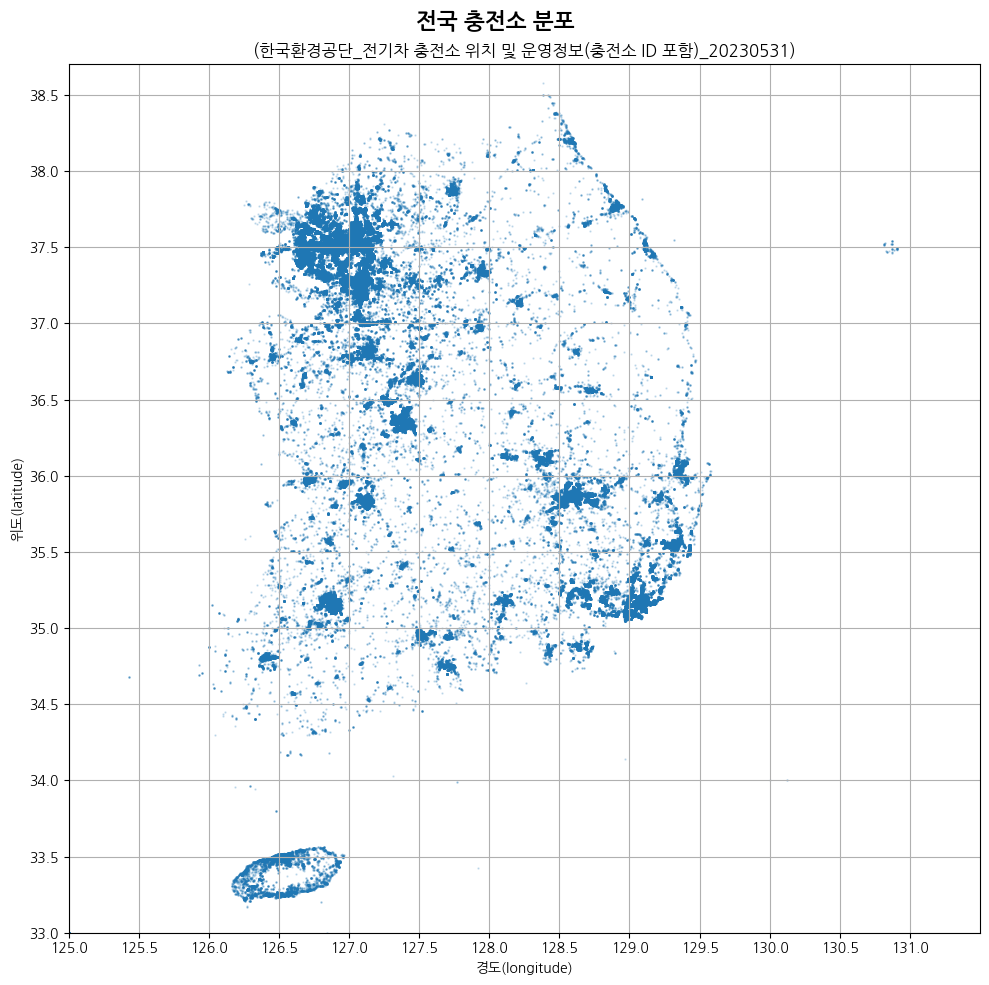

In [ ]:
# 경위도 데이터를 matplotlib로 시각화
plt.figure(figsize=(10, 10))

plt.scatter(
    keco_chargers_20230531['경도'],
    keco_chargers_20230531['위도'],
    alpha=0.2,
    s=0.5
)

plt.xlabel('경도(longitude)')
plt.xlim(*lng_lim)
plt.xticks(np.arange(*lng_lim, 0.5))
plt.ylabel('위도(latitude)')
plt.ylim(*lat_lim)
plt.yticks(np.arange(*lat_lim, 0.5))
plt.suptitle('전국 충전소 분포', fontsize=16, fontweight='bold')
plt.title('(한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531)')
plt.grid()
plt.tight_layout()
plt.show()

### 전체 충전기 종류별 산포도

In [ ]:
# 급속충전 종류
# qcharge_speeds = sorted(keco_chargers_20230531['급속충전량'].unique(), key=lambda x: (x is None, x))
qcharge_speeds = {
	'None':					{'size':1.0, 'alpha':0.8, 'color':'lightgrey'},
	'완속(30kW단독)':		{'size':1.0, 'alpha':0.9, 'color':'cyan'},
	'급속(50kW)':			{'size':1.0, 'alpha':0.9, 'color':'blue'},
	'급속(100kW단독)':		{'size':1.0, 'alpha':0.9, 'color':'green'},
	'급속(100kW동시)':		{'size':1.0, 'alpha':0.9, 'color':'green'},
	'급속(100kW멀티)':		{'size':1.0, 'alpha':0.9, 'color':'green'},
	'급속(200kW동시)':		{'size':1.0, 'alpha':0.9, 'color':'lightgreen'},
	'급속(300kW단독)':		{'size':1.0, 'alpha':0.9, 'color':'yellow'},
	'급속(300kW동시)':		{'size':1.0, 'alpha':0.9, 'color':'yellow'},
	'급속(400kW동시)':		{'size':2.0, 'alpha':0.9, 'color':'orange'},
	'초급속(350kW단독)':	{'size':3.0, 'alpha':1.0, 'color':'red'},
}

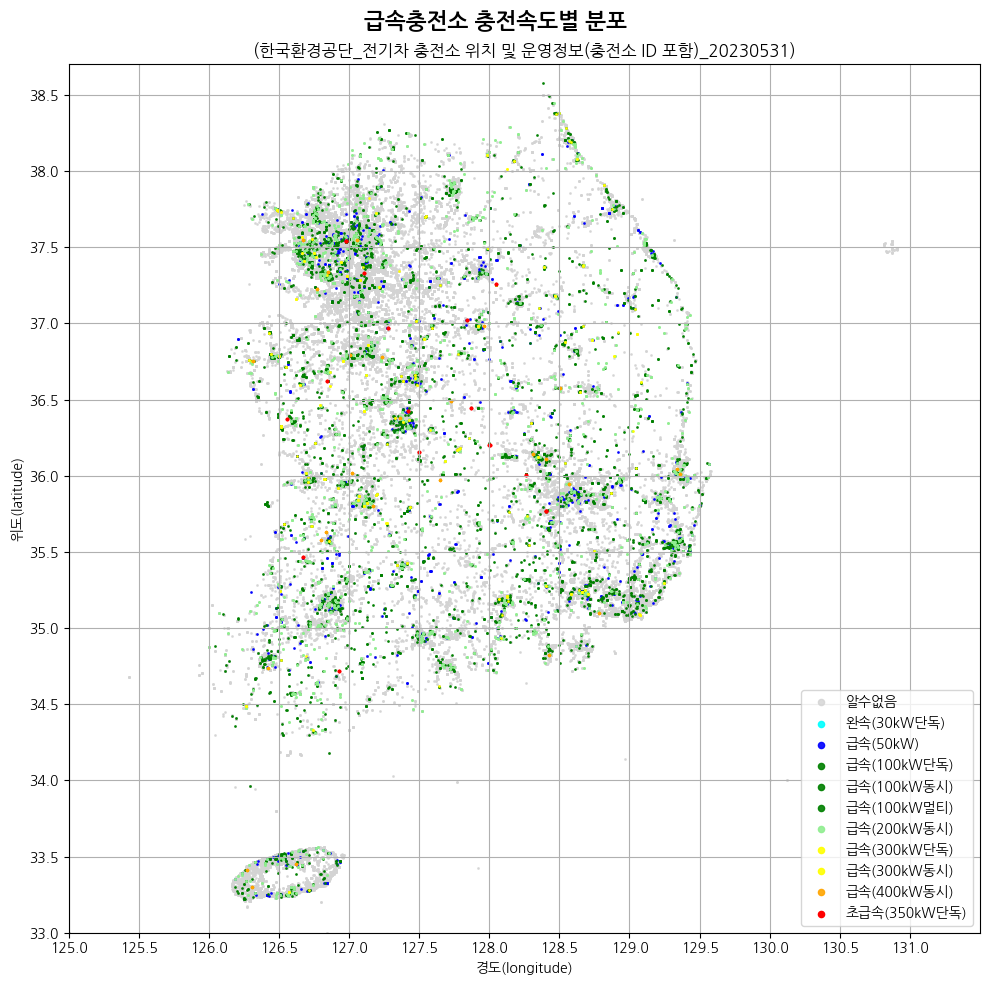

In [ ]:
# 경위도 데이터를 matplotlib로 시각화
plt.figure(figsize=(10, 10))

plt.scatter(
	keco_chargers_20230531[keco_chargers_20230531['급속충전량'].isna()]['경도'],
	keco_chargers_20230531[keco_chargers_20230531['급속충전량'].isna()]['위도'],
	alpha=qcharge_speeds['None']['alpha'],
	s=qcharge_speeds['None']['size'],
	label='알수없음',
	color=qcharge_speeds['None']['color']
)
for qcs in qcharge_speeds.keys():
	if qcs == 'None':
		continue
	plt.scatter(
		keco_chargers_20230531[keco_chargers_20230531['급속충전량'] == qcs]['경도'],
		keco_chargers_20230531[keco_chargers_20230531['급속충전량'] == qcs]['위도'],
		alpha=qcharge_speeds[qcs]['alpha'],
		s=qcharge_speeds[qcs]['size'],
		label=qcs,
		color=qcharge_speeds[qcs]['color']
	)

plt.xlabel('경도(longitude)')
plt.xlim(*lng_lim)
plt.xticks(np.arange(*lng_lim, 0.5))
plt.ylabel('위도(latitude)')
plt.ylim(*lat_lim)
plt.yticks(np.arange(*lat_lim, 0.5))
plt.suptitle('급속충전소 충전속도별 분포', fontsize=16, fontweight='bold')
plt.title('(한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531)')
plt.grid()
l = plt.legend()
for handle in l.legend_handles:
	handle.set_sizes([20])
plt.tight_layout()
plt.show()

### 전체 충전소당 충전기 개수별 분포도

In [ ]:
# keco_chargers_20230531 ['충전소명']을 기준으로 groupby하고 각 grouped row의 수를 ['충전기수']로 저장
keco_chargers_20230531_count_by_stations = pd.merge(
	pd.DataFrame(keco_chargers_20230531.value_counts('주소')).rename(columns={'count': '충전기수'}),
	keco_chargers_20230531.drop_duplicates('주소', keep='first'),
	how='left',
	on='주소'
).sort_values('충전기수', ascending=True)
display(keco_chargers_20230531_count_by_stations)

,주소,충전기수,설치년도,시도,군구,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,위도,경도,source
70700,경상북도 예천군 예천읍 지내길 6-48,1,2022,경상북도,예천군,무한골프연습장,상업시설,골프장(CC),완속,AC완속,타기관,GS차지비,None,AC완속,이용자제한,36.6449420430000,128.4263094900000,dataset
53037,충청북도 청주시 상당구 교서로32번길 31,1,2017,충청북도,청주시,청주시 중앙동 주민센터,공공시설,주민센터,완속,AC완속,타기관(보조금),GS차지비,None,AC완속,이용가능,36.6398591937000,127.4882029254000,dataset
53038,강원특별자치도 속초시 동해대로 4337,1,2022,강원특별자치도,속초시,속초시(힐스템찜질우측가로등형충전기),기타시설,기타,완속,AC완속,타기관(보조금),파워큐브,None,AC완속,이용자제한,38.2022700000000,128.5685600000000,dataset
53039,충청북도 청주시 상당구 교동로 71,1,2021,충청북도,청주시,충북 청주시 상당구 수동 48-3 (저압수용가),기타시설,기타,완속,AC완속,타기관,스타코프,None,AC완속,이용자제한,36.6387800000000,127.4973640000000,dataset
53040,충청북도 청주시 상당구 단재로77번길 21-22,1,2018,충청북도,청주시,박인규,기타시설,기타,완속,AC완속,타기관(보조금),채비,None,AC완속,비공개,36.6224954000000,127.4968948000000,naver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,부산광역시 사하구 다대낙조2길 100,234,2024,부산광역시,사하구,다대롯데캐슬몰운대(301동-411동),공동주택시설,아파트,완속,AC완속,타기관(보조금),LG유플러스,None,AC완속,이용가능,35.0553800000000,128.9648330000000,dataset
3,경기도 김포시 고촌읍 태리로 236,240,2022,경기도,김포시,캐슬앤파밀리에시티1단지,공동주택시설,아파트,완속,AC완속,타기관,스타코프,None,AC완속,이용자제한,37.5950359000000,126.7550481000000,dataset
2,서울특별시 서대문구 가재울미래로 2,243,2024,서울특별시,서대문구,DMC파크뷰자이아파트,공동주택시설,아파트,완속,AC완속,타기관(보조금),GS차지비,None,AC완속,이용자제한,37.5744203630000,126.9178973700000,dataset
1,서울특별시 송파구 송파대로 345,257,2021,서울특별시,송파구,서울시 송파구 헬리오시티아파트,공동주택시설,아파트,완속,AC완속,타기관,GS차지비,None,AC완속,이용가능,37.4970145690000,127.1070018000000,dataset


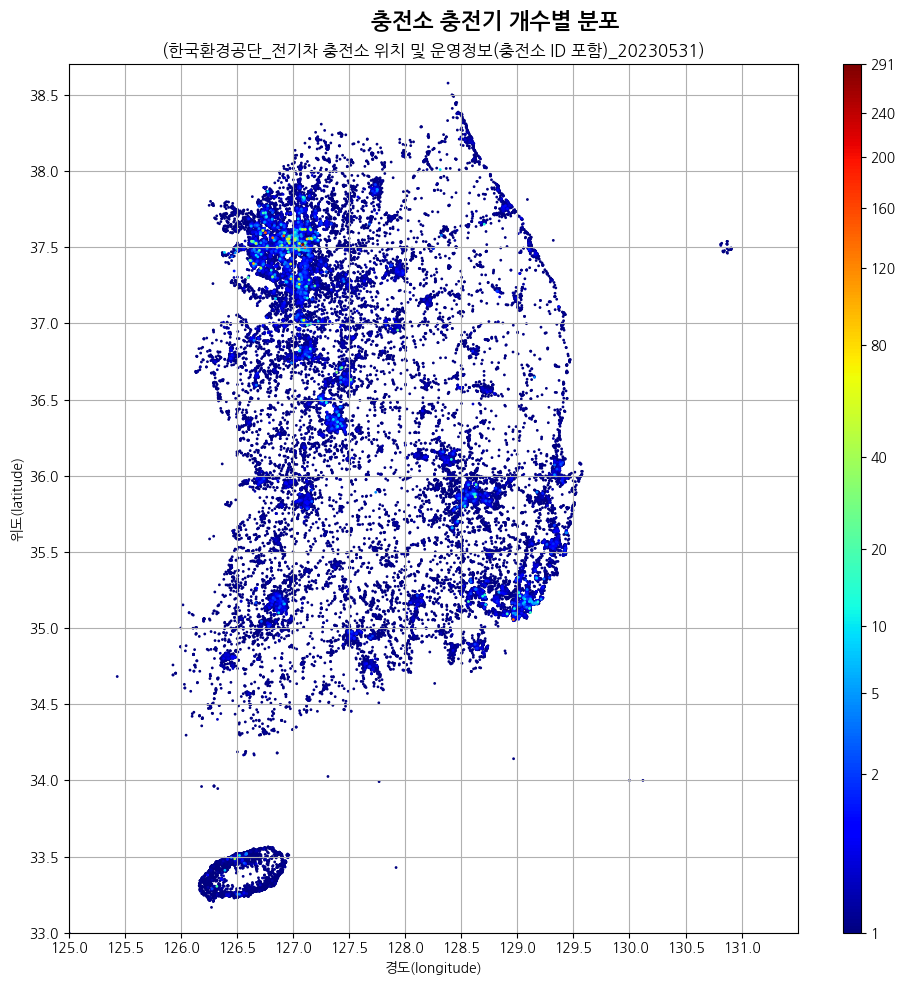

In [ ]:
# 경위도 데이터를 matplotlib로 시각화
fig = plt.figure(figsize=(10, 10))
fig.set_facecolor('white')

chargers_per_stations = keco_chargers_20230531_count_by_stations['충전기수'].unique()
chargers_cmap = plt.get_cmap('jet')
# chargers_cmap = cm.bwr #plt.cm.get_cmap('bwr')

# for i in range(len(chargers_per_stations)):
# 	d = keco_chargers_20230531_count_by_stations[keco_chargers_20230531_count_by_stations['충전기수'] == chargers_per_stations[i]]
plt.scatter(
	keco_chargers_20230531_count_by_stations['경도'],
	keco_chargers_20230531_count_by_stations['위도'],
	# alpha=0.9,
	s=1,
	c=keco_chargers_20230531_count_by_stations['충전기수'],
	cmap=chargers_cmap
)


plt.xlabel('경도(longitude)')
plt.xlim(*lng_lim)
plt.xticks(np.arange(*lng_lim, 0.5))
plt.ylabel('위도(latitude)')
plt.ylim(*lat_lim)
plt.yticks(np.arange(*lat_lim, 0.5))
plt.suptitle('충전소 충전기 개수별 분포', fontsize=16, fontweight='bold')
plt.title('(한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531)')
plt.grid()
plt.tight_layout()

# Normalization; https://matplotlib.org/stable/users/explain/colors/colormapnorms.html
# chargers_cmap_normalize = matplotlib.colors.LogNorm(
#     vmin=keco_chargers_20230531_count_by_stations['충전기수'].min(),
#     vmax=keco_chargers_20230531_count_by_stations['충전기수'].max(),
#     # vmax: 전체 데이터 중 표준편차 2배 이내의 값 중 최대값
#     # vmax = keco_chargers_20230531_count_by_stations['충전기수'].mean() + 2 * keco_chargers_20230531_count_by_stations['충전기수'].std(),
# )
chargers_cmap_normalize = matplotlib.colors.PowerNorm(
    gamma=0.3,
    vmin=keco_chargers_20230531_count_by_stations['충전기수'].min(),
    vmax=keco_chargers_20230531_count_by_stations['충전기수'].max(),
    # vmax: 전체 데이터 중 표준편차 2배 이내의 값 중 최대값
    # vmax = keco_chargers_20230531_count_by_stations['충전기수'].mean() + 2 * keco_chargers_20230531_count_by_stations['충전기수'].std(),
)

# 컬러바, log scaling
chargers_colormapping = cm.ScalarMappable(
	norm=chargers_cmap_normalize,
	cmap=chargers_cmap
)
chargers_colorbars = fig.colorbar(
    chargers_colormapping,
    ax=plt.gca(),
    orientation='vertical',
    aspect=50
)
chargers_colorbars.set_ticks([1,2,5,10,20,40,80,120,160,200,240,keco_chargers_20230531_count_by_stations['충전기수'].max()])

plt.show()

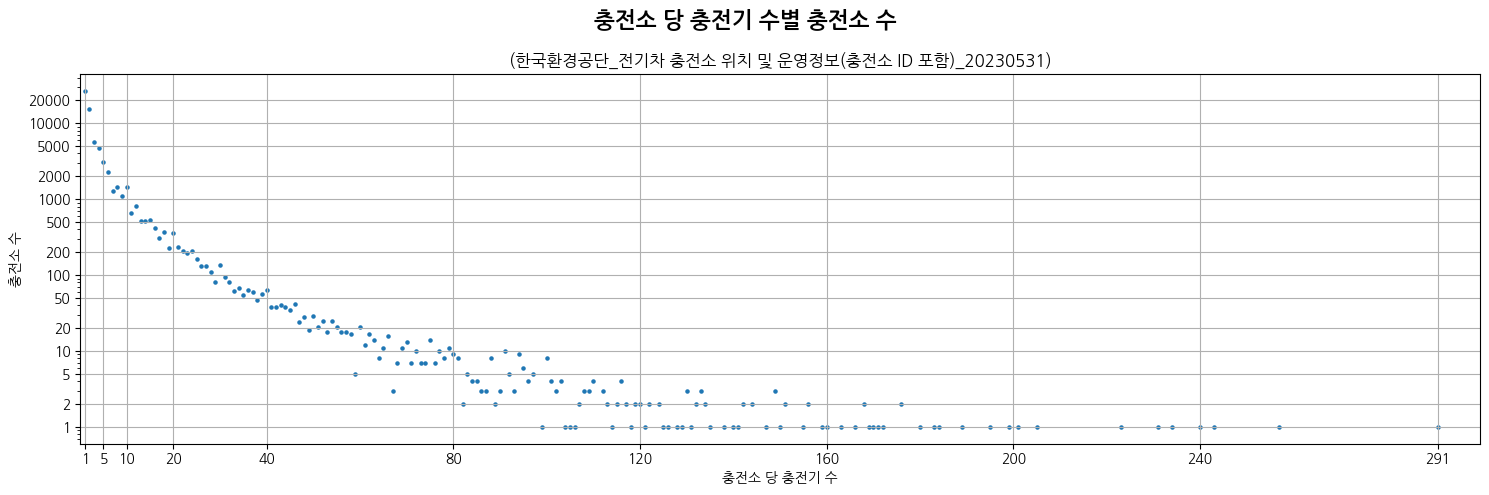

In [ ]:
keco_chargers_20230531_count_by_stations_grouped = keco_chargers_20230531_count_by_stations.groupby('충전기수').count()['충전소명']

plt.figure(figsize=(15, 5))
plt.scatter(
	keco_chargers_20230531_count_by_stations_grouped.index,
	keco_chargers_20230531_count_by_stations_grouped.values,
	s=5
)

plt.xlabel('충전소 당 충전기 수')
plt.xlim(0, 300)
plt.xticks([1, 5, 10, 20, 40, 80, 120, 160, 200, 240, keco_chargers_20230531_count_by_stations_grouped.index.max()])

plt.ylabel('충전소 수')
plt.yscale('log')
plt.yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.suptitle('충전소 당 충전기 수별 충전소 수', fontsize=16, fontweight='bold')
plt.title('(한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531)')

plt.grid()
plt.tight_layout()
plt.show()

### 지역별 충전기 수 통계 (원 그래프)

In [ ]:
keco_chargers_20230531_by_regions = pd.DataFrame(keco_chargers_20230531.groupby(['시도','군구']).count()['주소']).reset_index()
keco_chargers_20230531_by_regions.rename(columns={'주소': '충전소수'}, inplace=True)
keco_chargers_20230531_by_regions.sort_values(['시도', '충전소수'], inplace=True, ascending=[True, False])
display(keco_chargers_20230531_by_regions)

,시도,군구,충전소수
8,강원특별자치도,원주시,3409
12,강원특별자치도,춘천시,2507
0,강원특별자치도,강릉시,1760
4,강원특별자치도,속초시,675
2,강원특별자치도,동해시,613
...,...,...,...
220,충청북도,괴산군,208
223,충청북도,영동군,193
227,충청북도,증평군,181
221,충청북도,단양군,155


In [ ]:
keco_chargers_20230531_by_regions2 = keco_chargers_20230531_by_regions.groupby('시도').agg({'충전소수': 'sum', '군구':'count'}).reset_index()
display(keco_chargers_20230531_by_regions2)

,시도,충전소수,군구
0,강원특별자치도,12893,18
1,경기도,98048,31
2,경상남도,19798,18
3,경상북도,17084,23
4,광주광역시,10249,5
5,대구광역시,18332,9
6,대전광역시,10990,5
7,부산광역시,21749,16
8,서울특별시,57088,25
9,세종특별자치시,4639,1


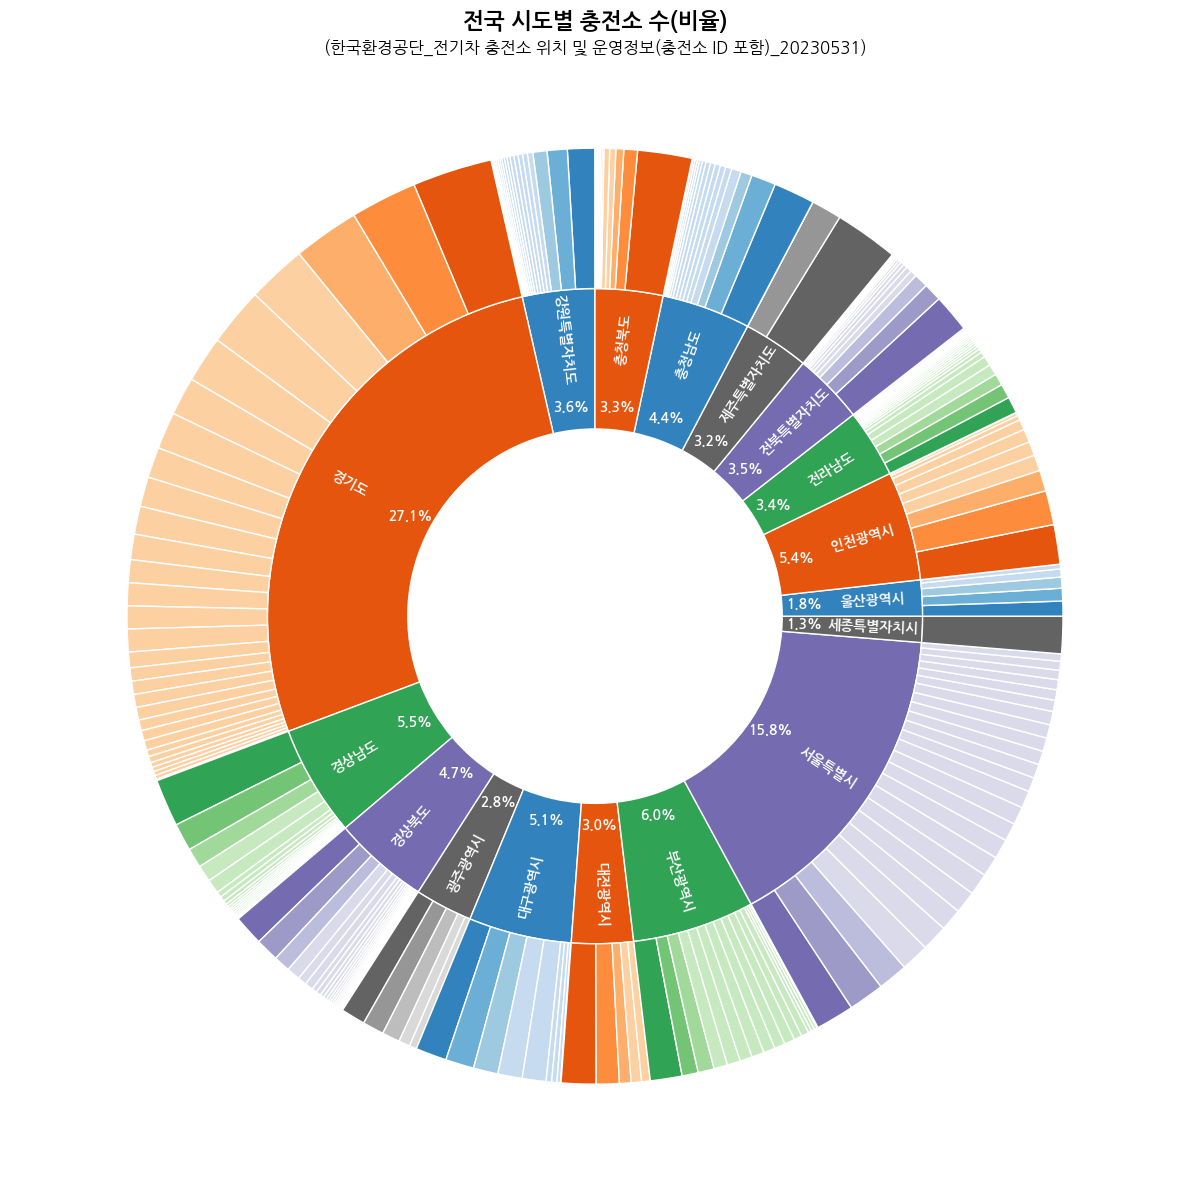

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('equal')
width = 0.3
cm = plt.get_cmap("tab20c")

# Inner ring color
colors_in_target = np.arange(0,5)*4
colors_in = cm(colors_in_target)

# Inner ring
pie_in, pie_in_labels, pie_in_pcts = ax.pie(
    keco_chargers_20230531_by_regions2['충전소수'],
    radius=1-width,
    colors=colors_in,
    labels=keco_chargers_20230531_by_regions2['시도'],
    labeldistance=1-width*0.5,
    rotatelabels =True,
    autopct="%.1f%%",
    pctdistance=1-width*1.2,
    startangle=90,
    textprops={'fontsize': 10, 'color':'white', 'horizontalalignment':'center', 'verticalalignment':'center', 'fontweight':'bold'}
)
plt.setp(
    pie_in,
    width=width,
    edgecolor='white'
)

# Outer ring color
colors_out_partial = [0,1,2]+[3]*(keco_chargers_20230531_by_regions2['군구'].max()-3)
colors_out_target = np.array([])
for i in range(len(keco_chargers_20230531_by_regions2)):
    colors_out_target = np.append(colors_out_target, np.array(colors_out_partial[:keco_chargers_20230531_by_regions2['군구'][i]]) + colors_in_target[i%5])
colors_out = cm(colors_out_target/20.)

# Outer ring label mask
colors_out_labelmask = np.array([])
for i in range(len(keco_chargers_20230531_by_regions2)):
    colors_out_labelmask = np.append(colors_out_labelmask, np.array(colors_out_partial[:keco_chargers_20230531_by_regions2['군구'][i]]))
colors_out_labelmask = (colors_out_labelmask < 2)

# Outer ring
pie_out, pie_out_labels = ax.pie(
    keco_chargers_20230531_by_regions['충전소수'],
    radius=1,
    labeldistance=0.7,
    colors=colors_out,
    startangle=90
)
plt.setp(
    pie_out,
    width=width,
    edgecolor='white'
)

plt.suptitle('전국 시도별 충전소 수(비율)', fontsize=16, fontweight='bold')
plt.title('(한국환경공단_전기차 충전소 위치 및 운영정보(충전소 ID 포함)_20230531)')
plt.tight_layout()
plt.show()

test